In [3]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.ipc_collect()
#device = "cpu"

In [125]:
 def metric_calc(model,X,y,x_biased,metric=None):
    predictions = np.array(model(X).tolist()).flatten()
    if metric is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metric(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    return (1/JSD,R50)
    
def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN',f=None,ptype=0,dynamicbins=True):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    metrics_test = Metrics(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    scores = predictions[y==1]
    if dynamicbins:
        sorted_m = np.argsort(m)
        scores = scores[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = bins[:-1]
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
        else:
            passed = [(scores[digitized==i]<cut).sum()/(digitized==i).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
            
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=3)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    if f is not None:
        fig.savefig(f)
    plt.show()
    return (1/JSD,R50)

In [5]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

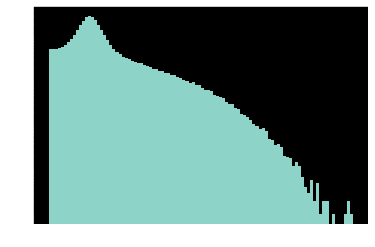

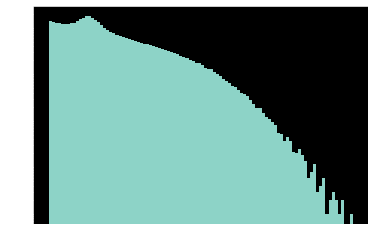

device: cuda:0


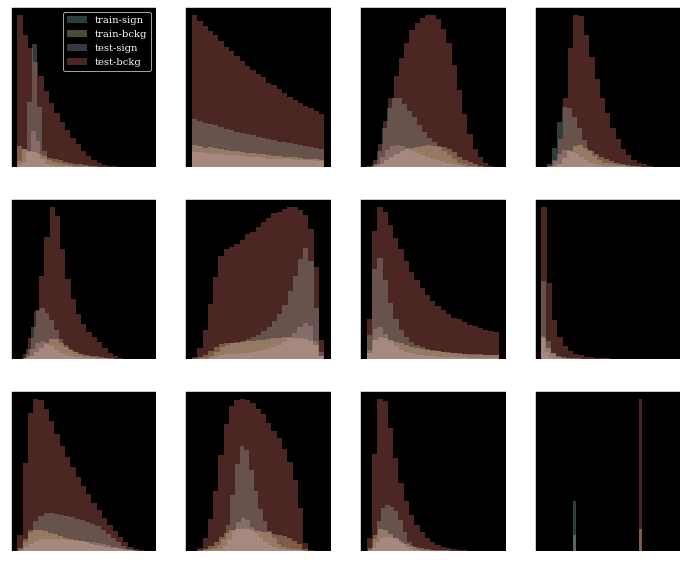

In [126]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

data = np.concatenate([train,val,test],axis=0)
maxdata = data.max(axis=0)
mindata = data.min(axis=0)
data = (data-mindata)/(maxdata-mindata)
data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1

train = data[:train.shape[0]]
val = data[train.shape[0]:val.shape[0]+train.shape[0]]
test = data[val.shape[0]+train.shape[0]:]




plt.hist(train[::,0],bins=100,log=True)
plt.show()
plt.hist(val[::,0],bins=100,log=True)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float().to(device)

print('device:', device)

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
fig.savefig("./logs/new/32768/data.pdf")

In [106]:
params = {'epochs'     : 200,
          'interval'   : 200,
          'batch_size' : 2048*2,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

# Flat str

strength 1
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (286.5s)
 Train: loss:0.2024, acc:79% || Val: loss: 0.0533, acc:83%, R50: 26.7358, 1/JSD: 2.9003


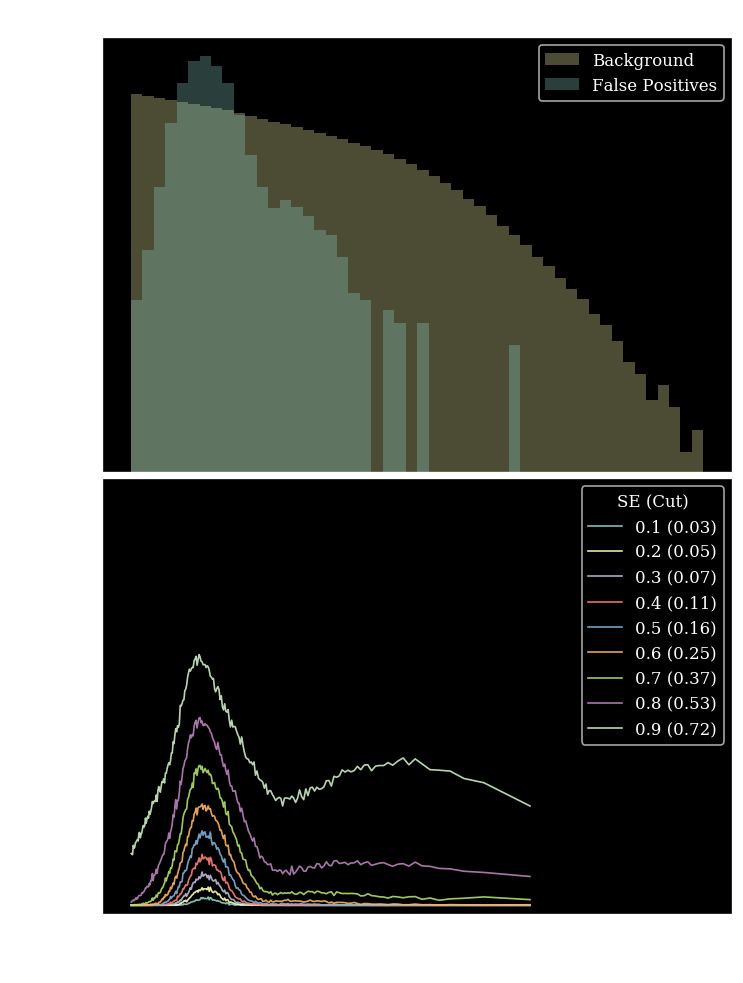

strength 1
Entering Training...
Epoch:0001/0200  (8.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (288.4s)
 Train: loss:0.2045, acc:79% || Val: loss: 0.0536, acc:83%, R50: 26.8314, 1/JSD: 3.0736


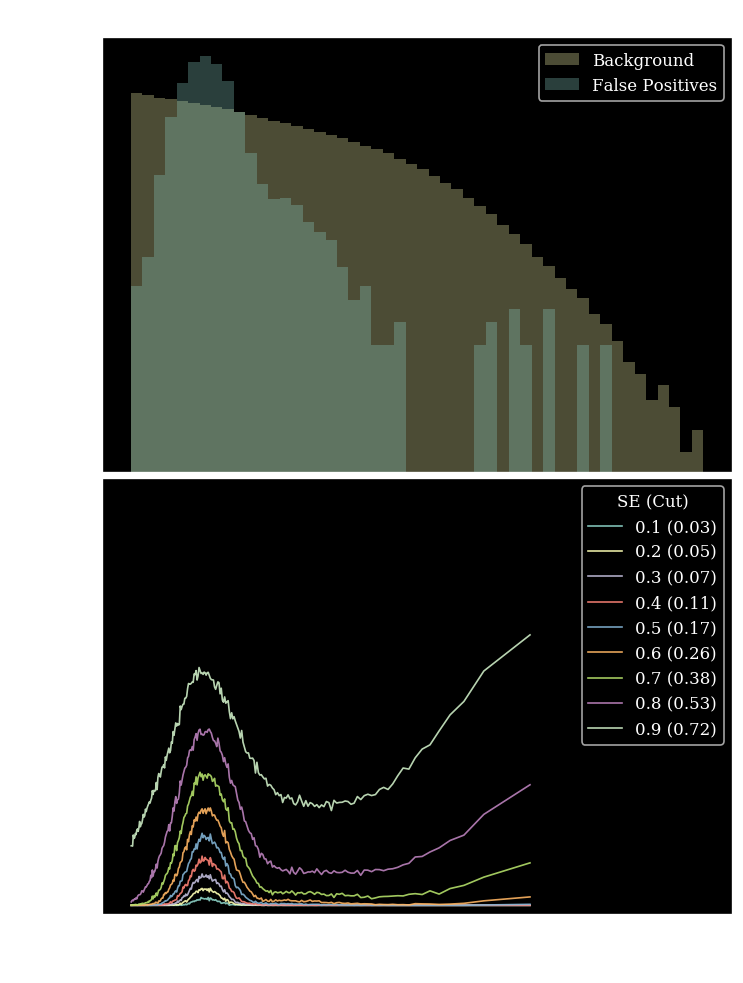

strength 1
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (300.0s)
 Train: loss:0.2062, acc:79% || Val: loss: 0.0537, acc:83%, R50: 26.6818, 1/JSD: 2.9659


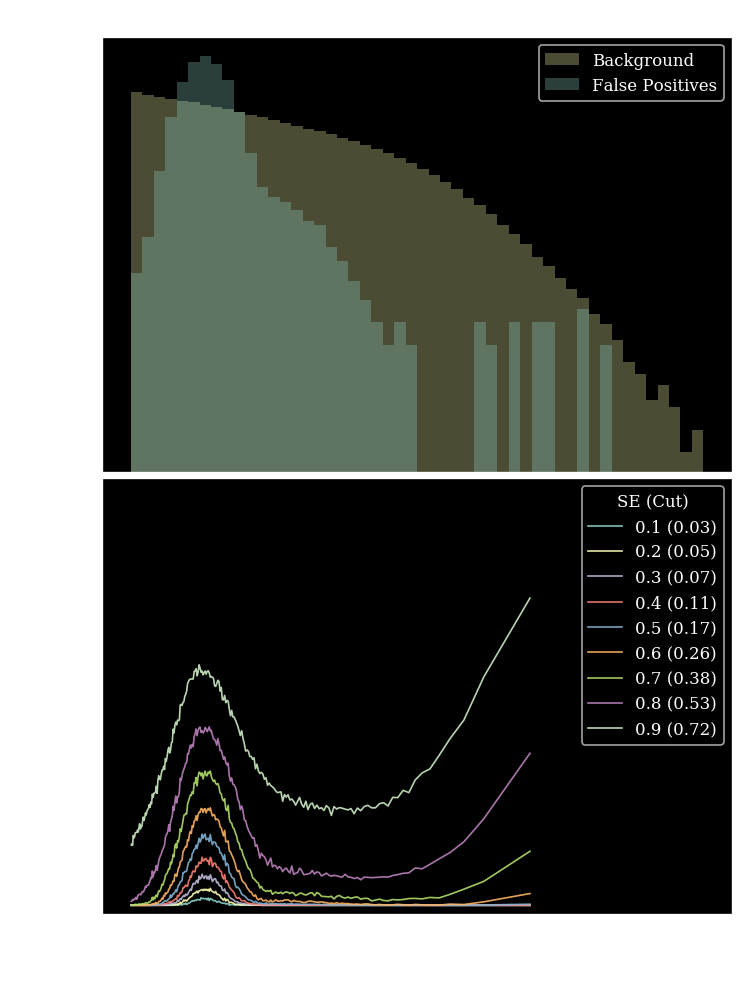

strength 1
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (295.3s)
 Train: loss:0.2146, acc:79% || Val: loss: 0.0538, acc:84%, R50: 26.5444, 1/JSD: 3.0372


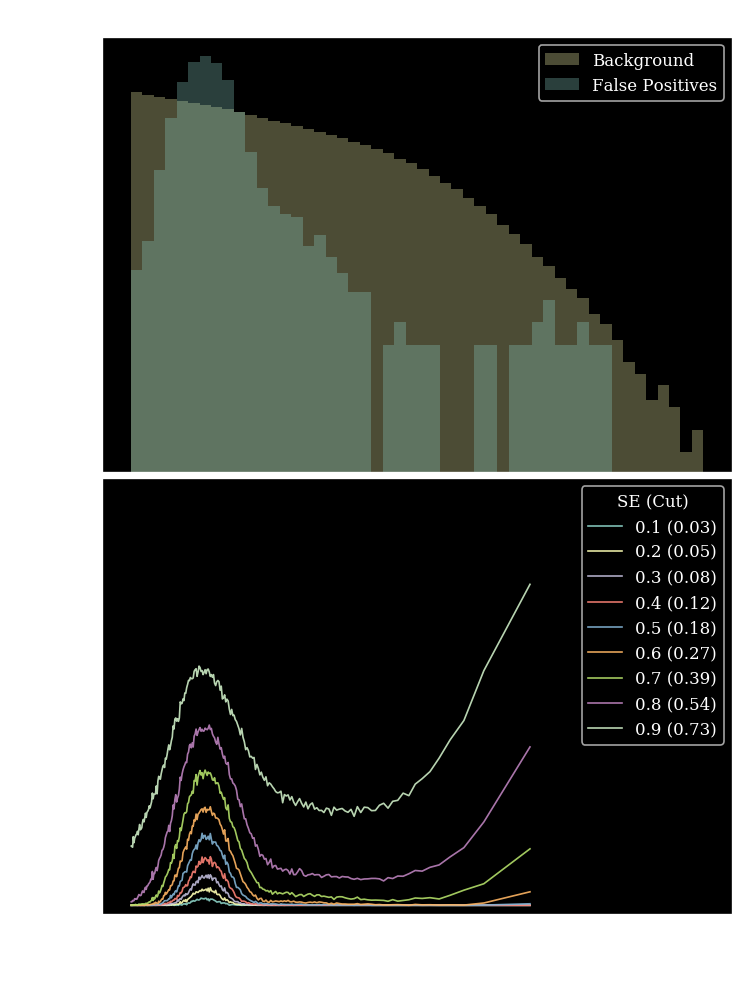

strength 20
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (294.8s)
 Train: loss:0.3320, acc:72% || Val: loss: 0.0711, acc:82%, R50: 17.1420, 1/JSD: 21.1148


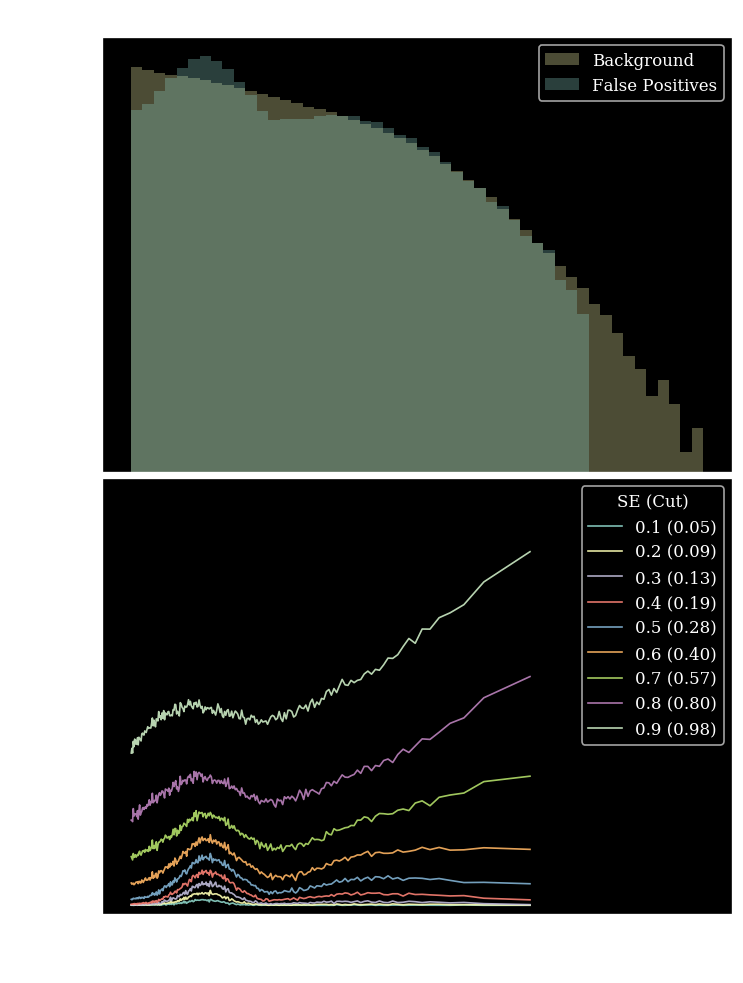

strength 20
Entering Training...
Epoch:0001/0200  (8.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (382.0s)
 Train: loss:0.3600, acc:71% || Val: loss: 0.0711, acc:83%, R50: 17.1437, 1/JSD: 22.3683


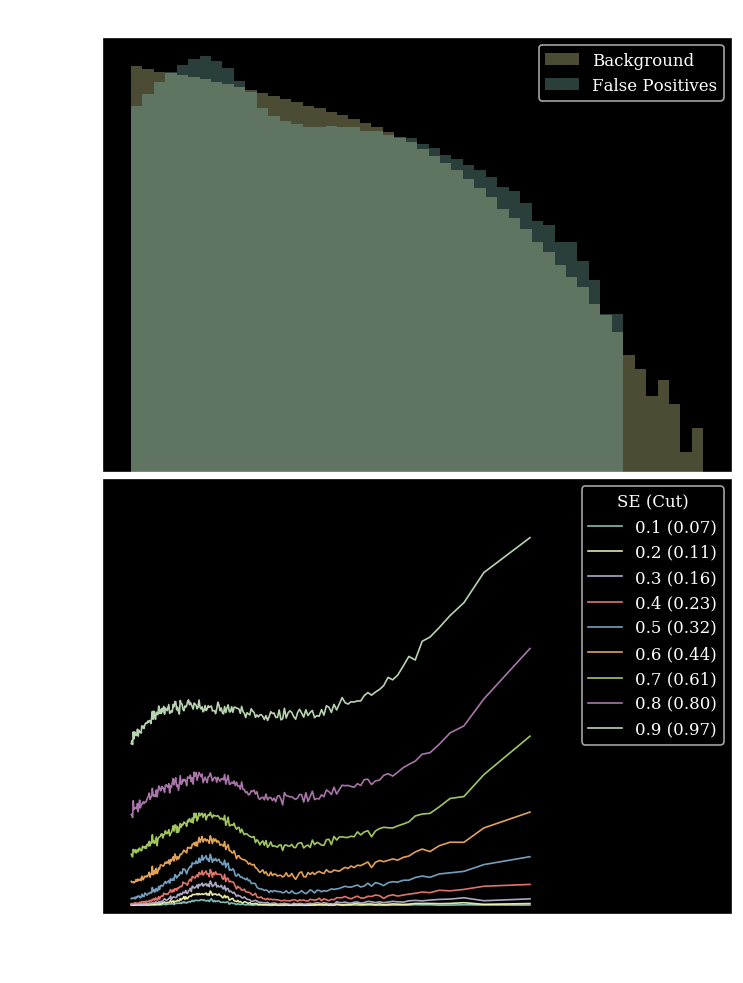

strength 20
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (300.1s)
 Train: loss:0.3918, acc:67% || Val: loss: 0.0761, acc:85%, R50: 18.4347, 1/JSD: 14.1488


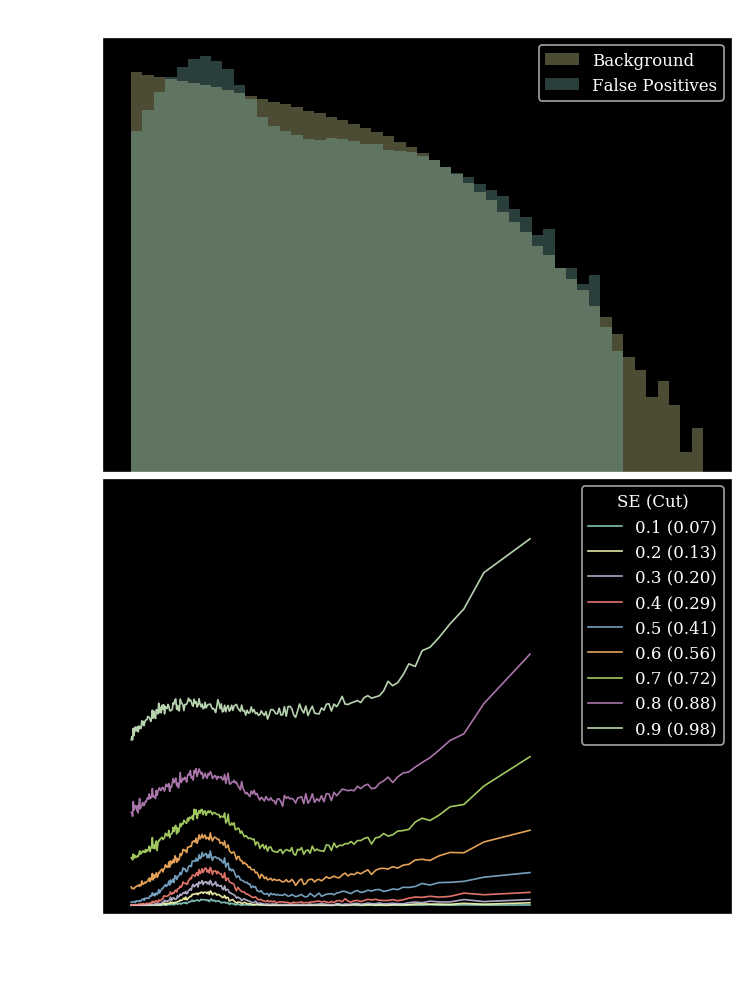

strength 20
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (293.2s)
 Train: loss:0.4305, acc:61% || Val: loss: 0.0909, acc:87%, R50: 21.7005, 1/JSD: 7.0672


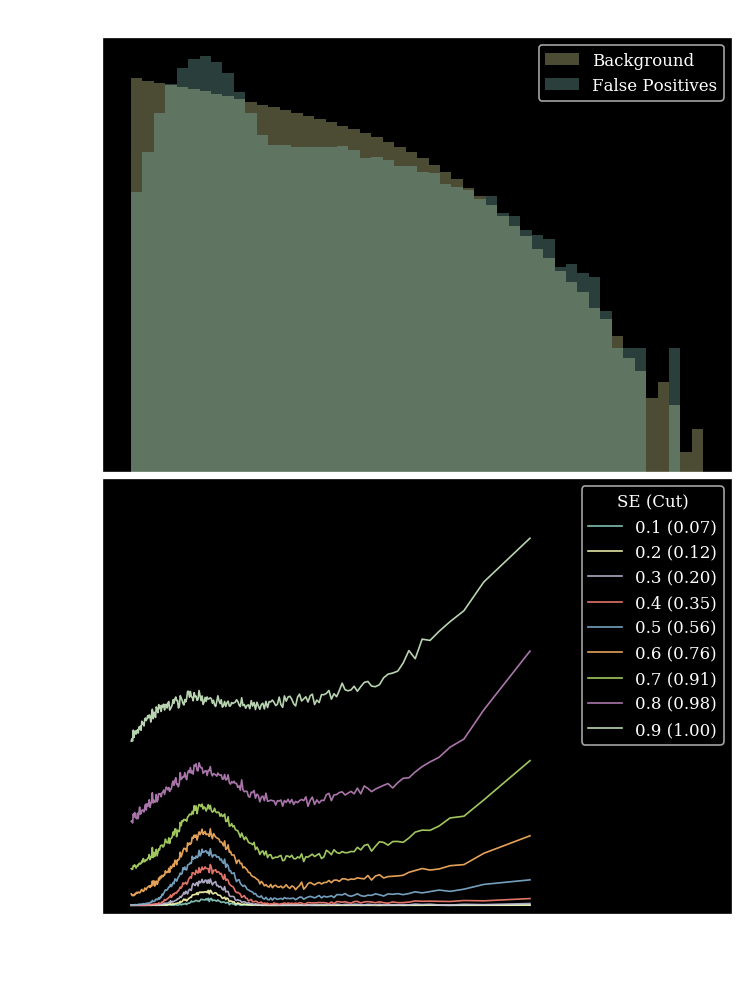

strength 45
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (353.1s)
 Train: loss:0.3838, acc:68% || Val: loss: 0.0811, acc:83%, R50: 14.1783, 1/JSD: 57.7207


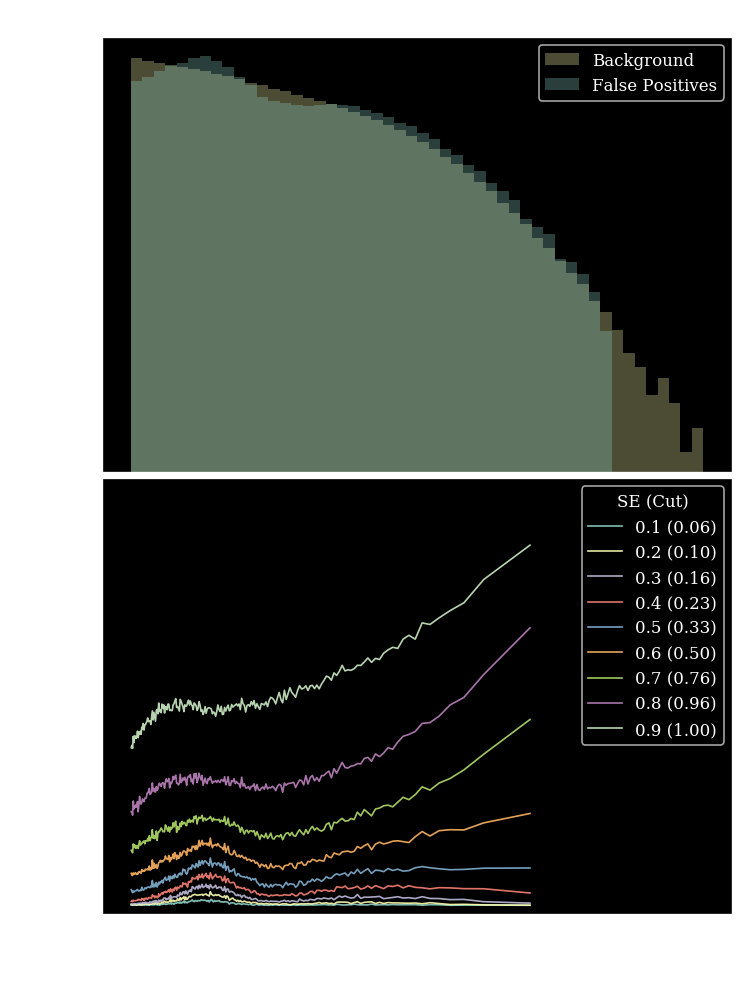

strength 45
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (288.6s)
 Train: loss:0.4262, acc:66% || Val: loss: 0.0845, acc:84%, R50: 14.8763, 1/JSD: 58.0736


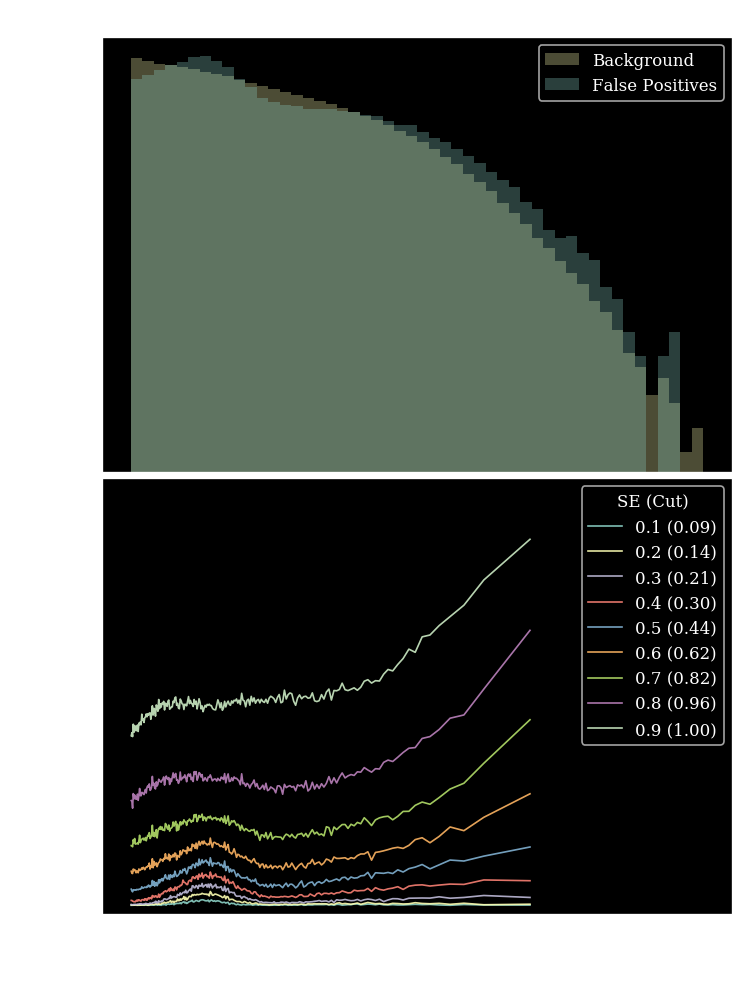

strength 45
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (300.1s)
 Train: loss:0.4694, acc:58% || Val: loss: 0.1013, acc:86%, R50: 16.7777, 1/JSD: 26.7738


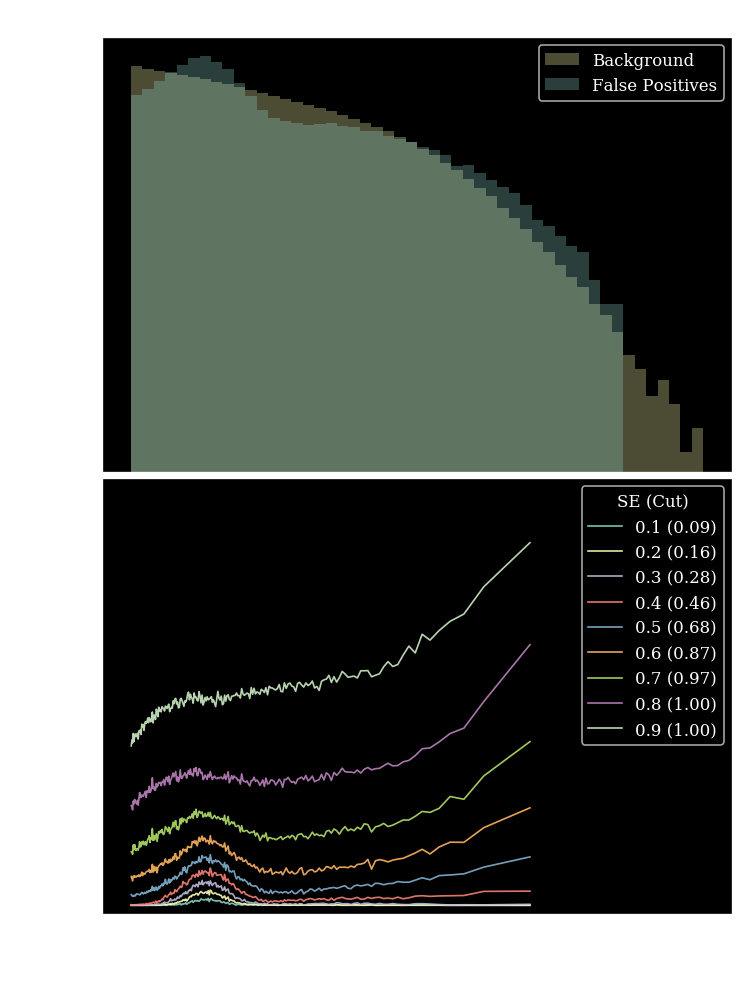

strength 45
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (362.0s)
 Train: loss:0.4981, acc:52% || Val: loss: 0.1230, acc:86%, R50: 21.6635, 1/JSD: 6.1149


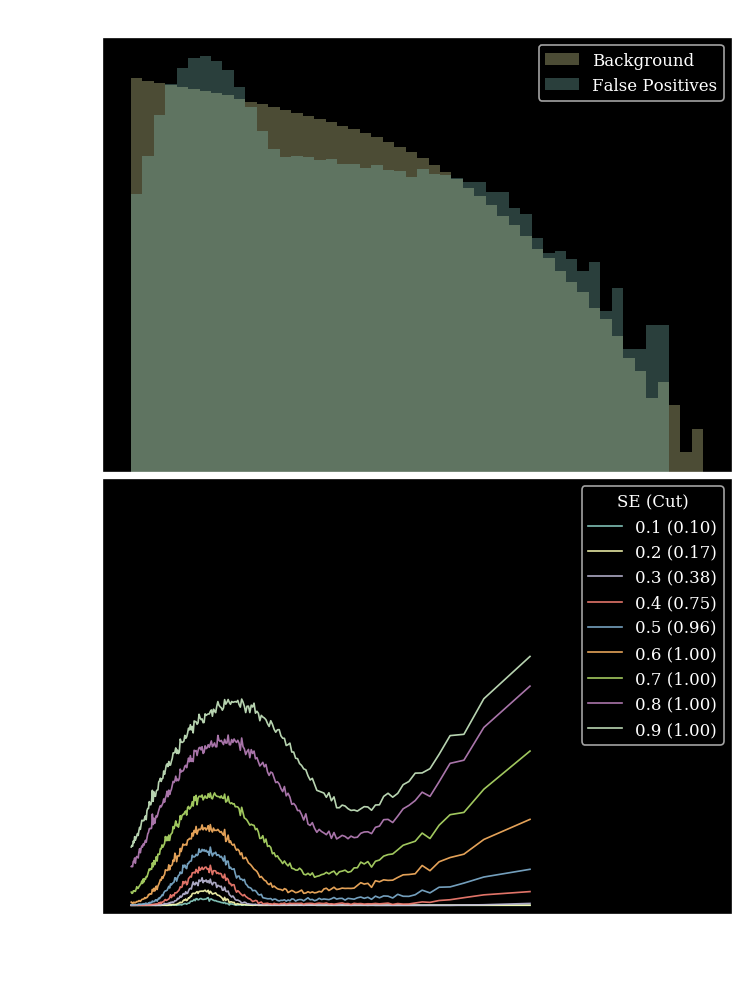

strength 75
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (288.0s)
 Train: loss:0.4189, acc:65% || Val: loss: 0.0896, acc:83%, R50: 13.1041, 1/JSD: 80.1403


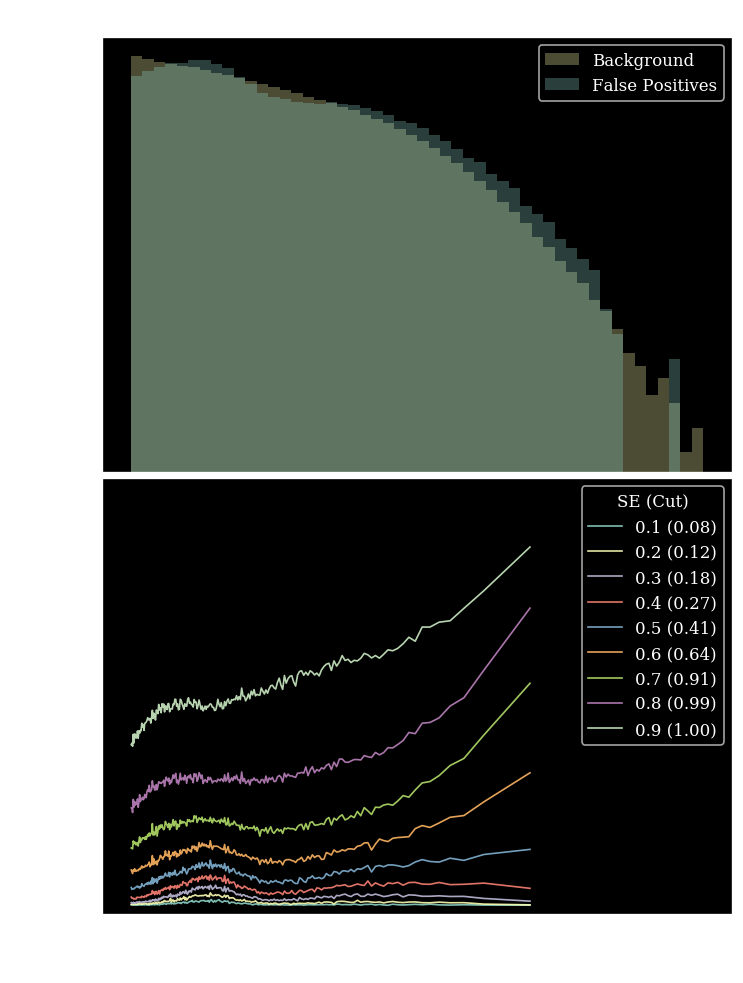

strength 75
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (290.5s)
 Train: loss:0.4662, acc:60% || Val: loss: 0.0978, acc:85%, R50: 14.0485, 1/JSD: 88.1982


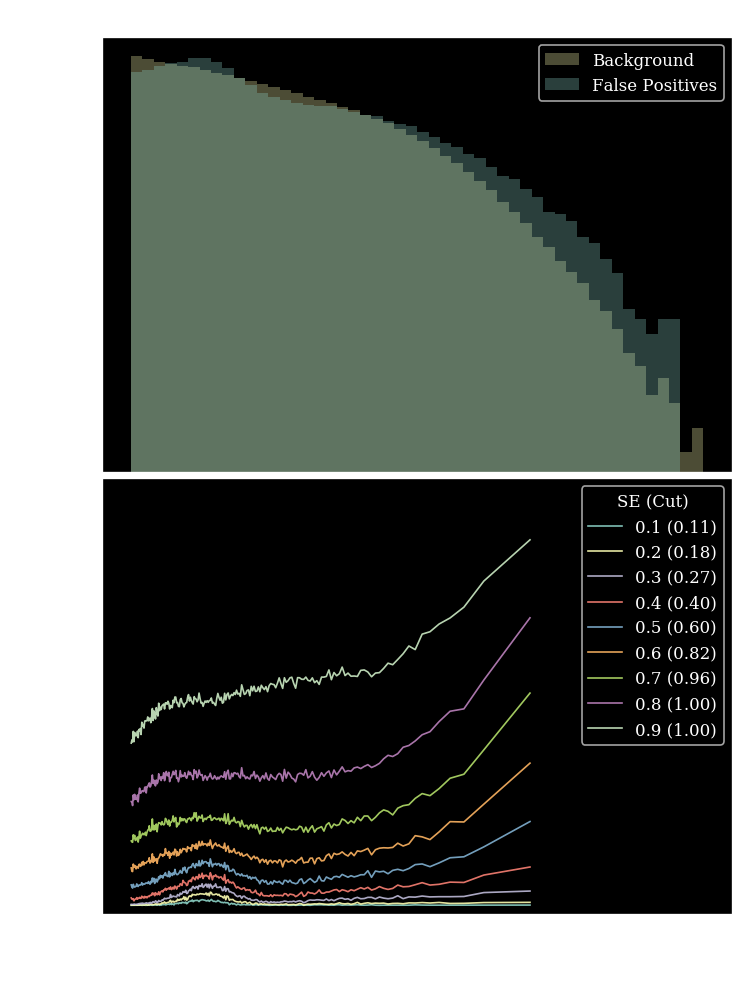

strength 75
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (368.1s)
 Train: loss:0.5171, acc:51% || Val: loss: 0.1228, acc:85%, R50: 15.8182, 1/JSD: 29.5482


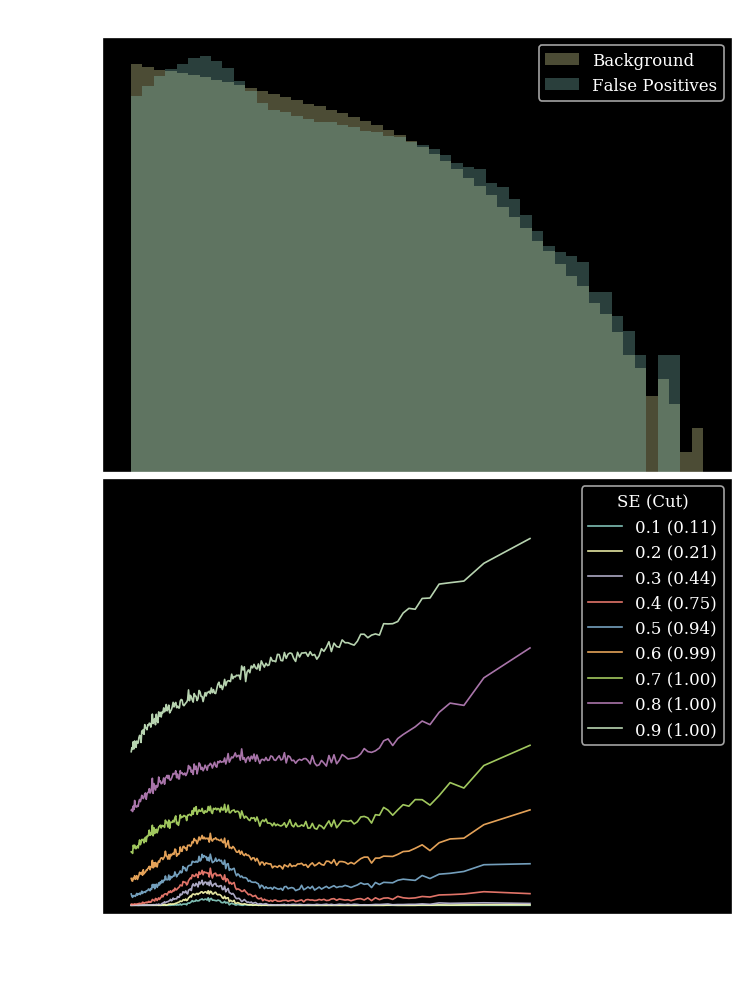

strength 75
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (292.5s)
 Train: loss:0.5421, acc:47% || Val: loss: 0.1408, acc:85%, R50: 21.7434, 1/JSD: 4.6206


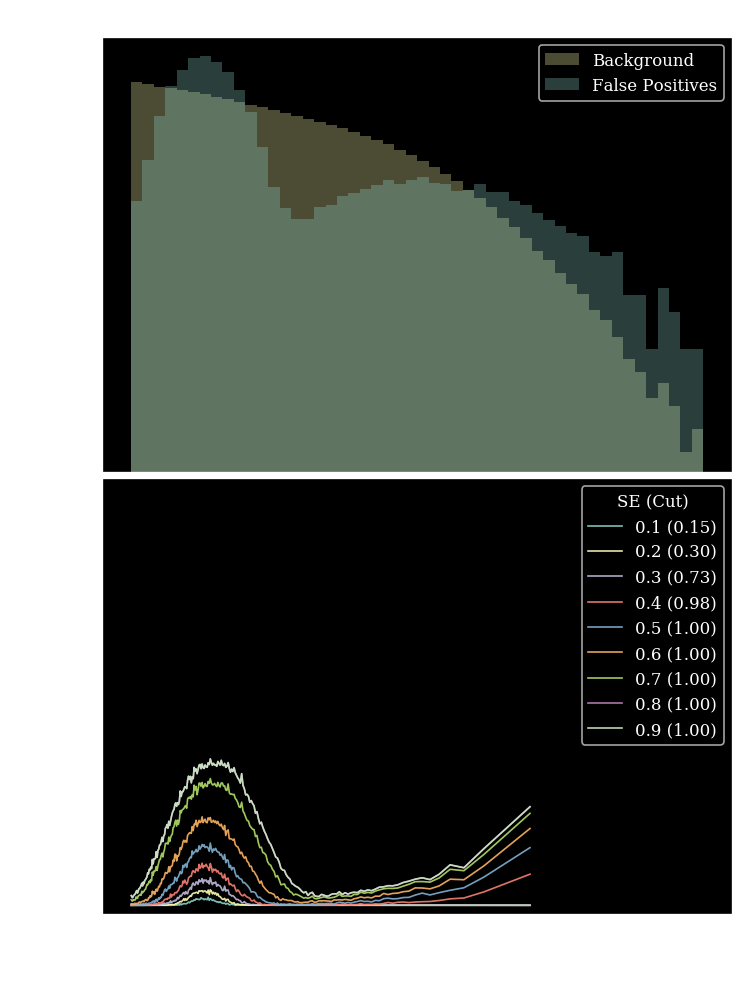

strength 100
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (289.4s)
 Train: loss:0.4386, acc:63% || Val: loss: 0.0947, acc:84%, R50: 12.7011, 1/JSD: 83.0389


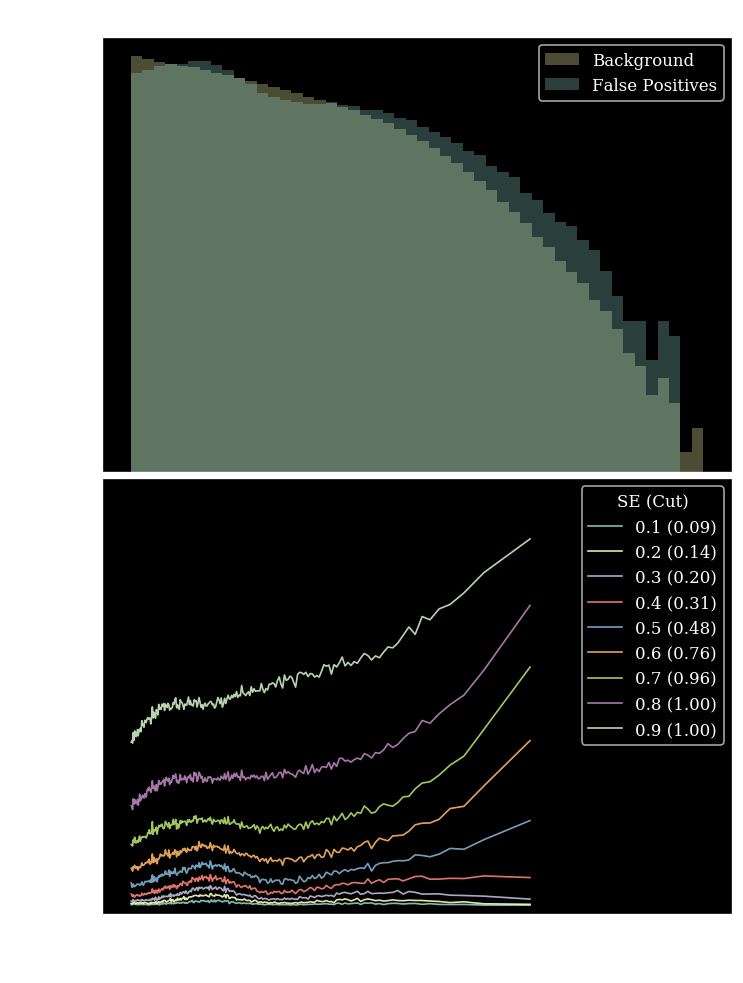

strength 100
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (361.4s)
 Train: loss:0.4882, acc:56% || Val: loss: 0.1072, acc:85%, R50: 13.0296, 1/JSD: 110.8712


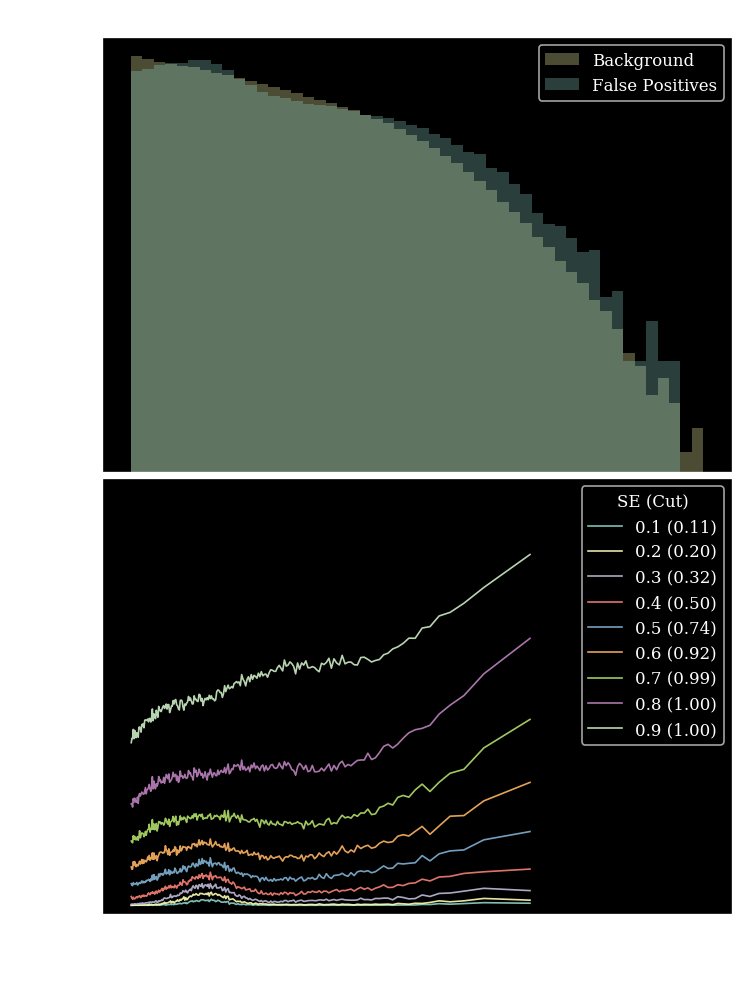

strength 100
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (301.3s)
 Train: loss:0.5412, acc:48% || Val: loss: 0.1331, acc:85%, R50: 16.6054, 1/JSD: 18.7356


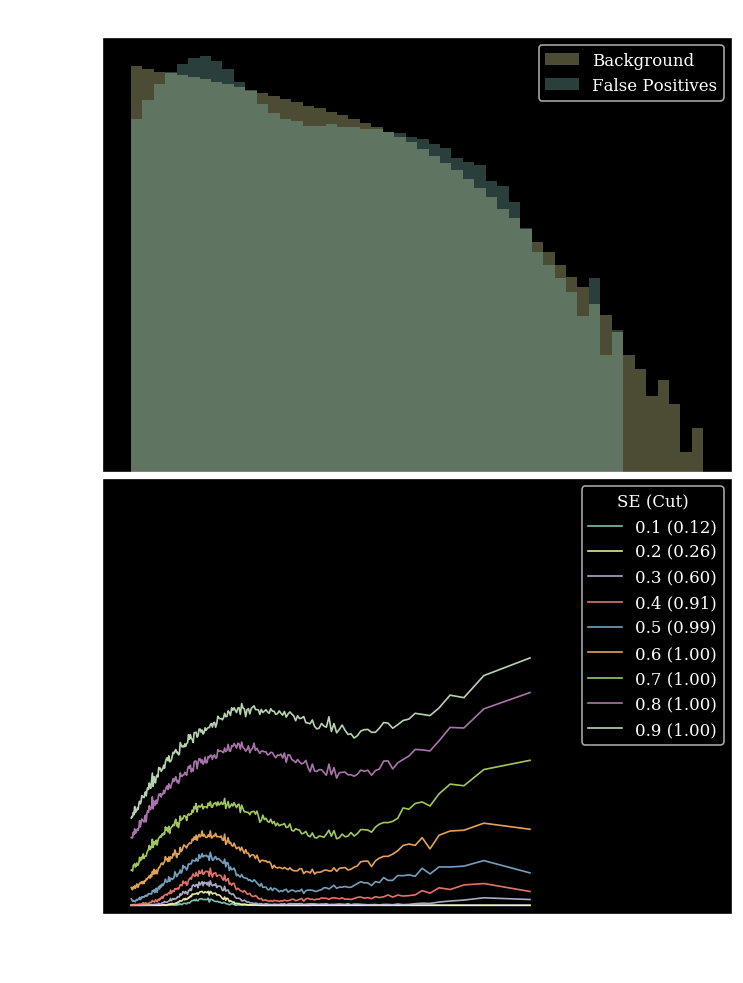

strength 100
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (295.9s)
 Train: loss:0.5704, acc:45% || Val: loss: 0.1489, acc:84%, R50: 21.8543, 1/JSD: 5.2019


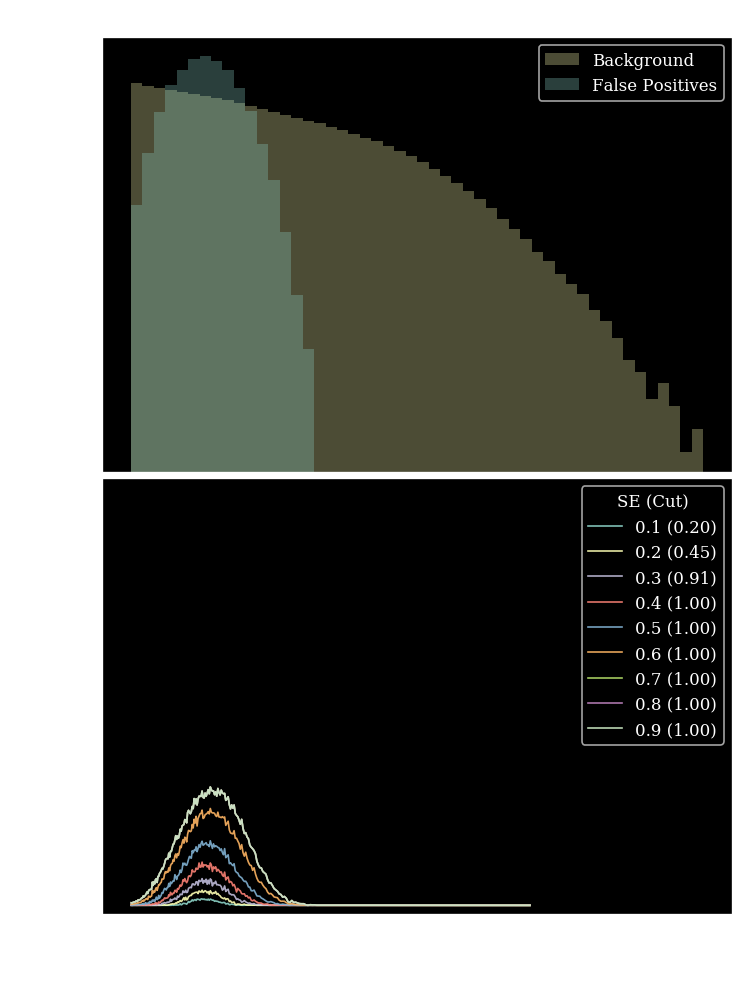

strength 125
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (355.6s)
 Train: loss:0.4553, acc:61% || Val: loss: 0.0993, acc:84%, R50: 12.4792, 1/JSD: 87.6064


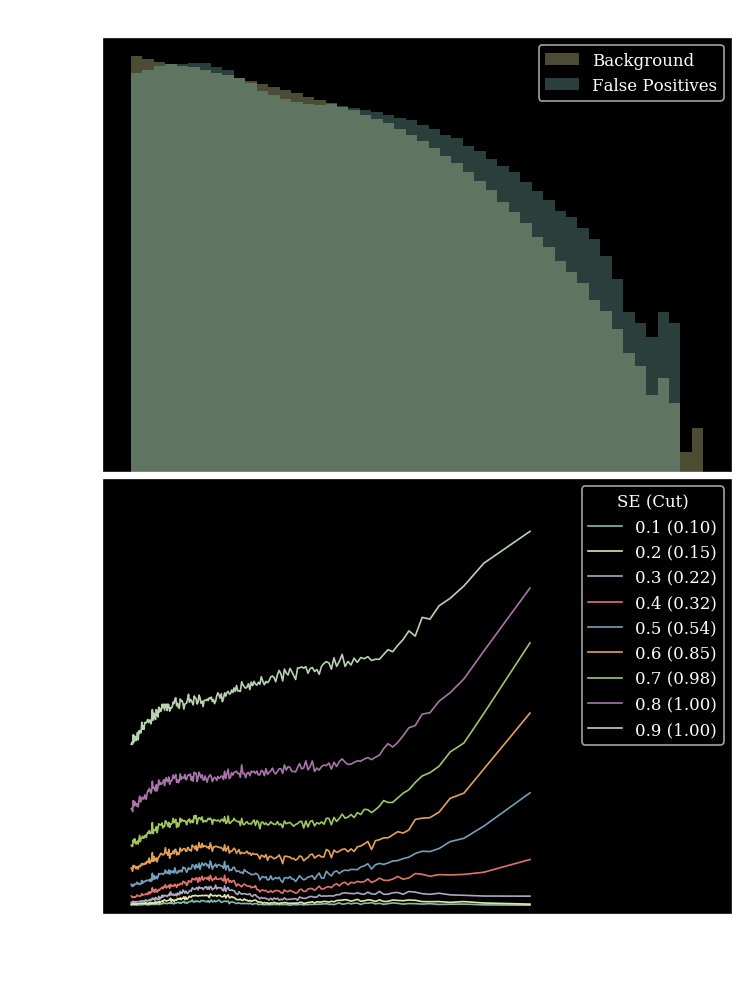

strength 125
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (291.9s)
 Train: loss:0.5151, acc:53% || Val: loss: 0.1153, acc:85%, R50: 12.5152, 1/JSD: 126.8015


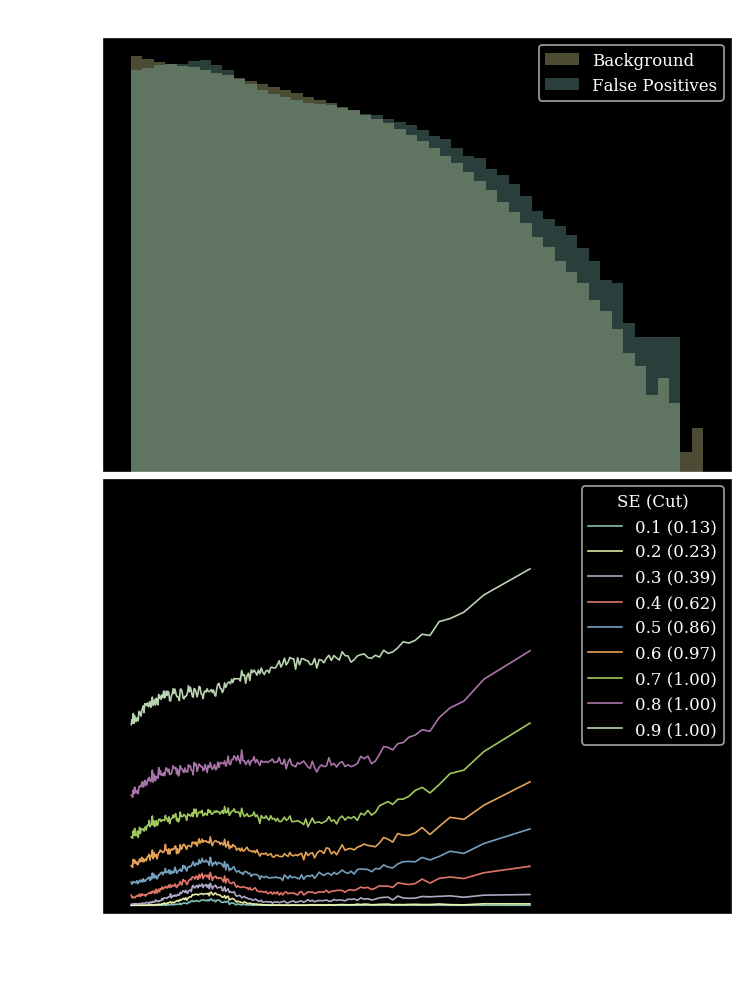

strength 125
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (300.1s)
 Train: loss:0.5546, acc:47% || Val: loss: 0.1408, acc:85%, R50: 18.4275, 1/JSD: 7.9651


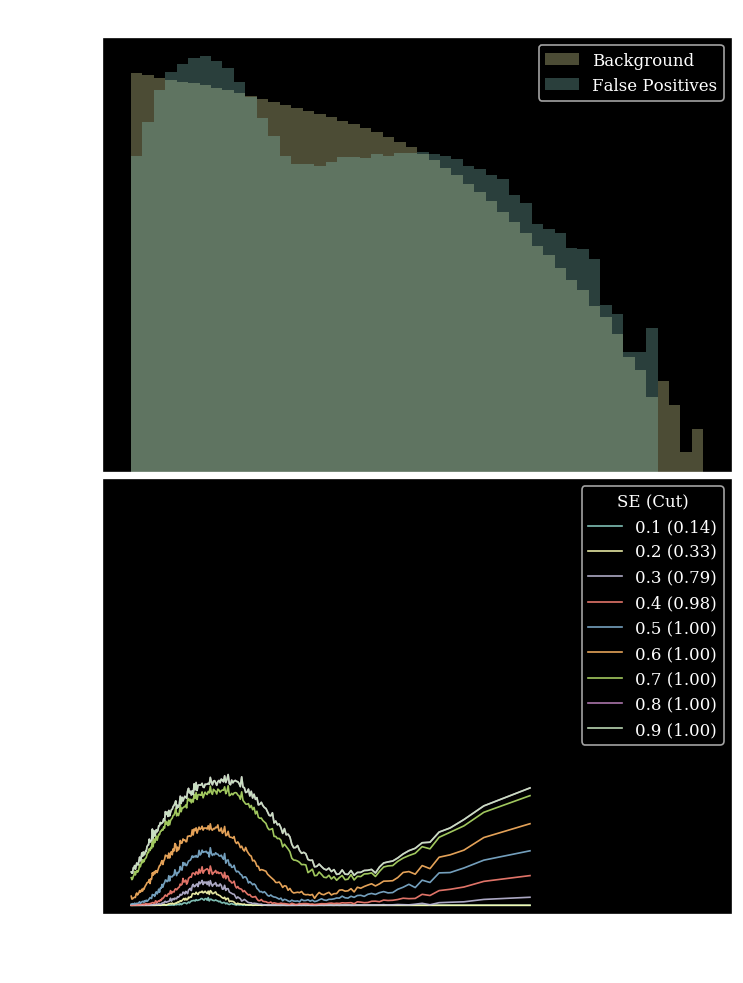

strength 125
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (360.5s)
 Train: loss:0.5966, acc:41% || Val: loss: 0.1558, acc:83%, R50: 19.1927, 1/JSD: 6.5706


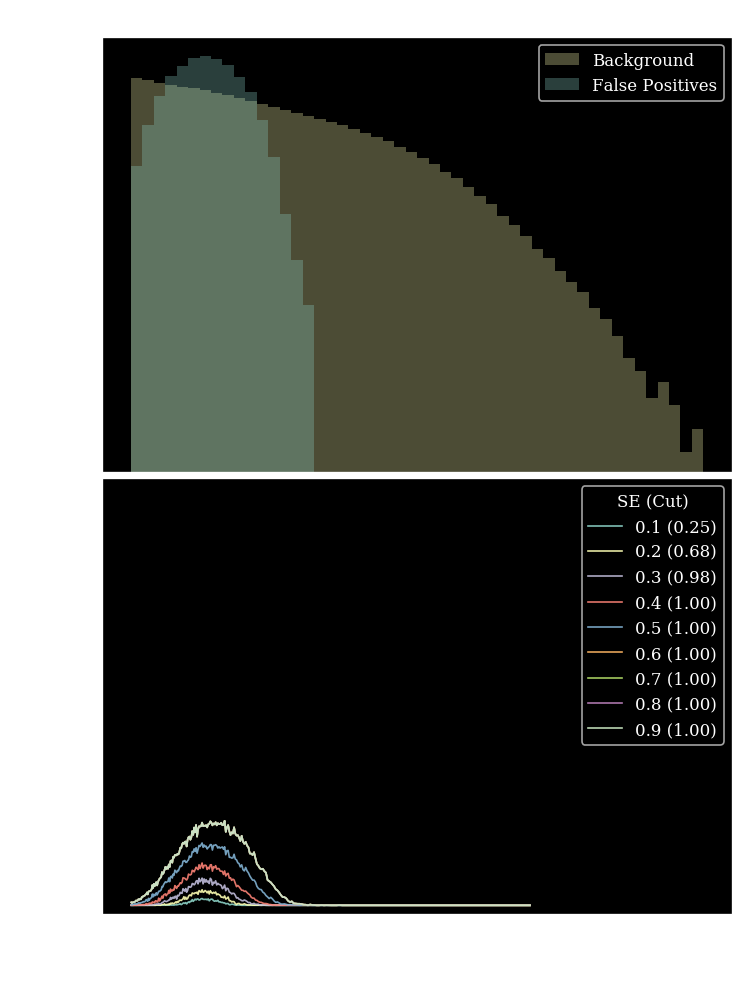

strength 200
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (287.6s)
 Train: loss:0.5092, acc:57% || Val: loss: 0.1113, acc:84%, R50: 11.6136, 1/JSD: 114.6120


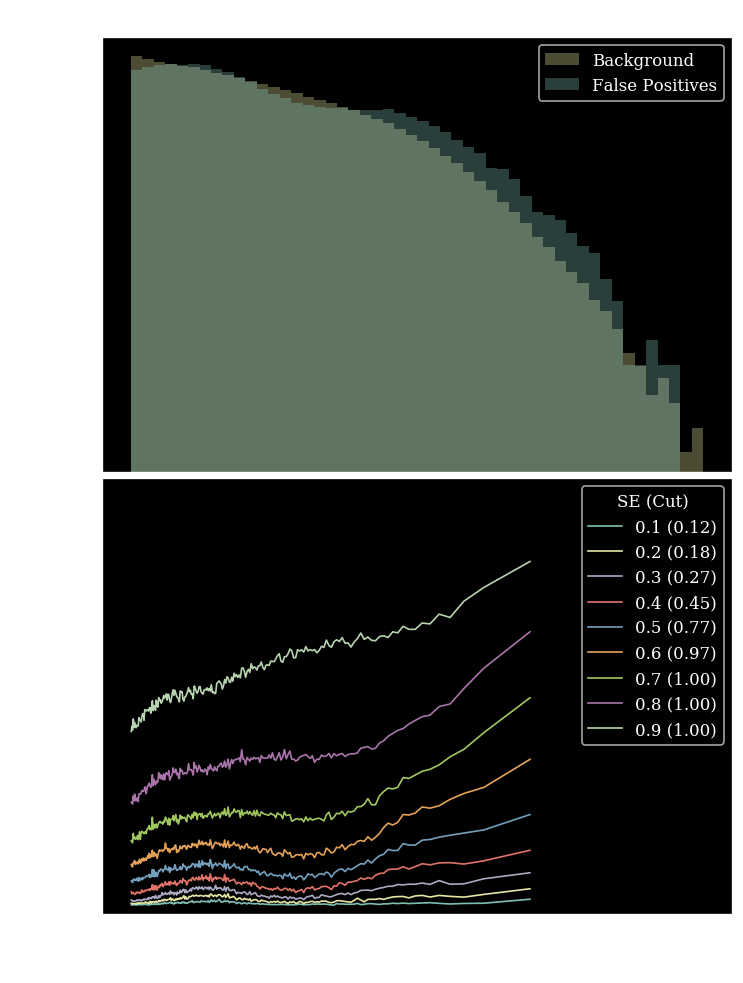

strength 200
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (290.7s)
 Train: loss:0.5674, acc:47% || Val: loss: 0.1333, acc:84%, R50: 11.8880, 1/JSD: 130.8165


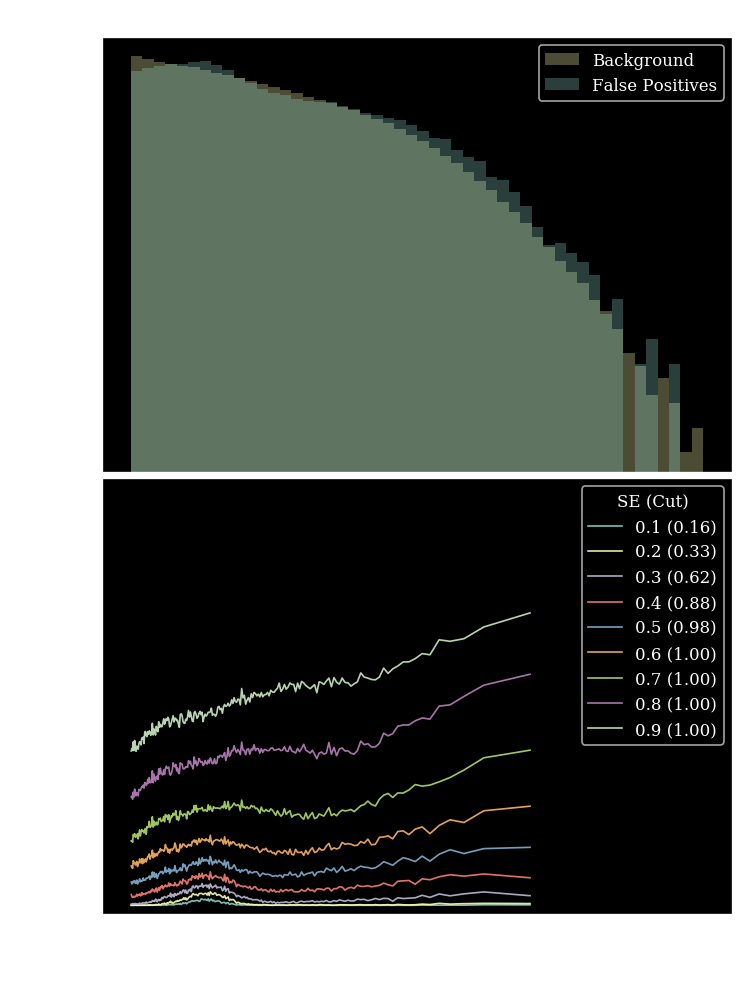

strength 200
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (365.5s)
 Train: loss:0.5887, acc:42% || Val: loss: 0.1553, acc:83%, R50: 18.2200, 1/JSD: 7.5651


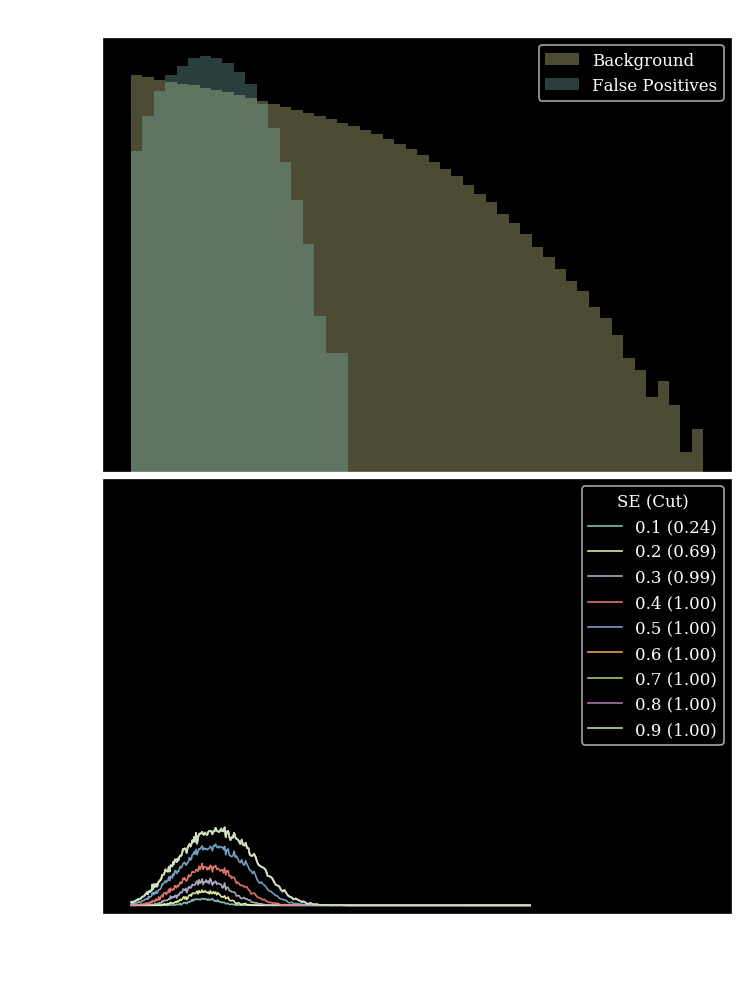

strength 200
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (295.8s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 10.6157, 1/JSD: 699.6140


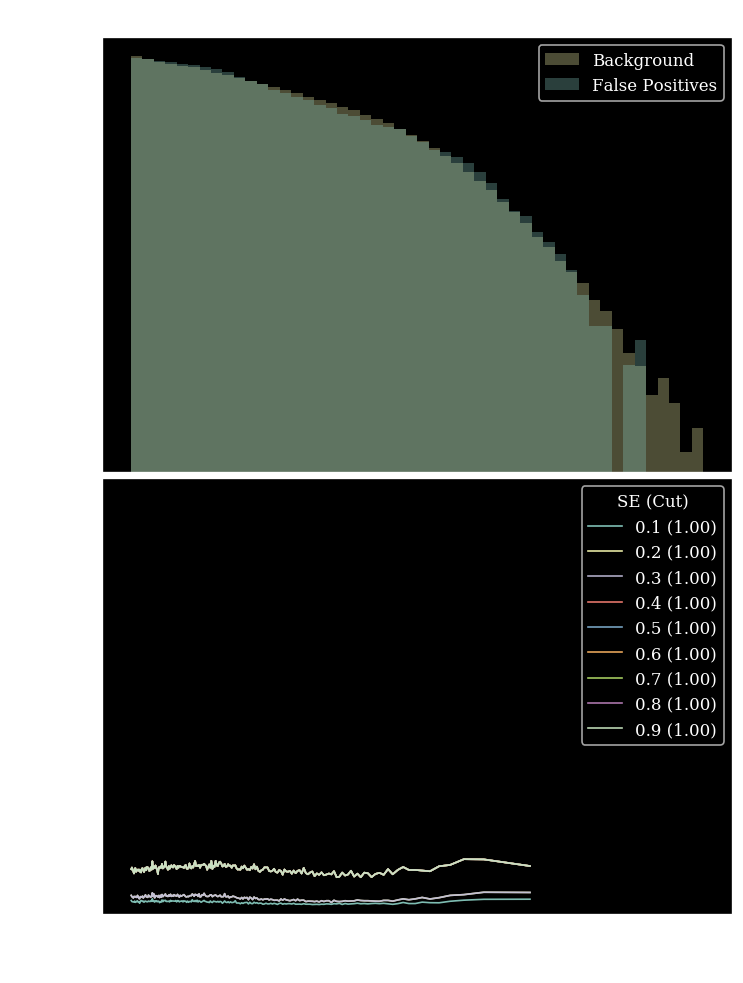

strength 500
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (291.3s)
 Train: loss:0.5747, acc:48% || Val: loss: 0.1374, acc:84%, R50: 10.2376, 1/JSD: 272.6044


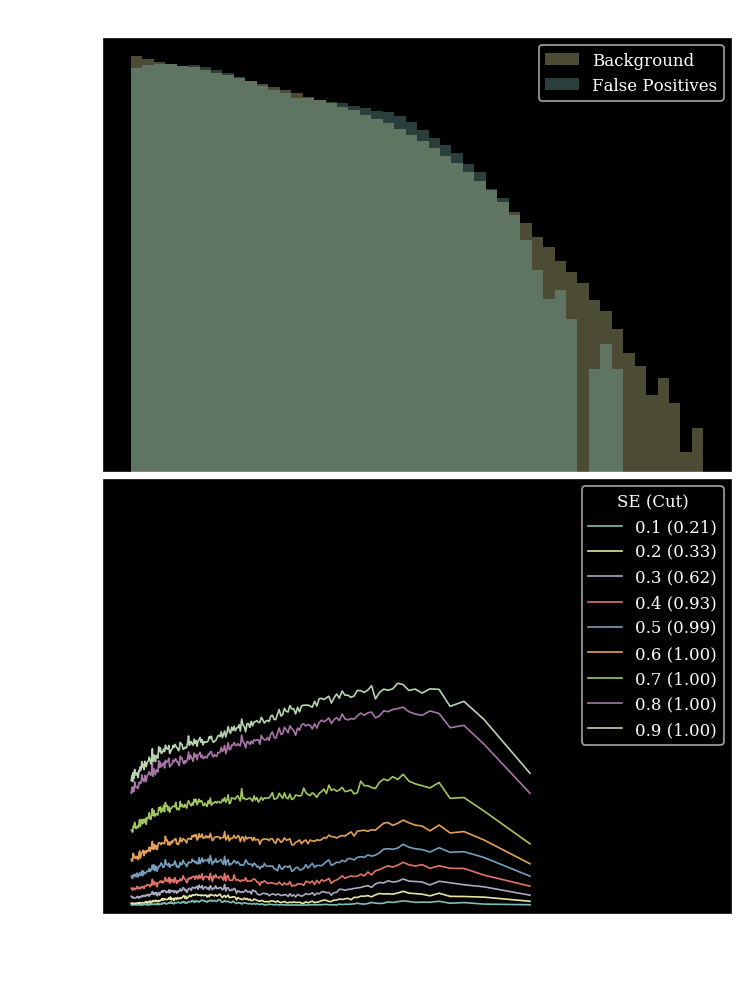

strength 500
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (357.6s)
 Train: loss:0.6274, acc:38% || Val: loss: 0.1692, acc:82%, R50: 19.4656, 1/JSD: 10.6317


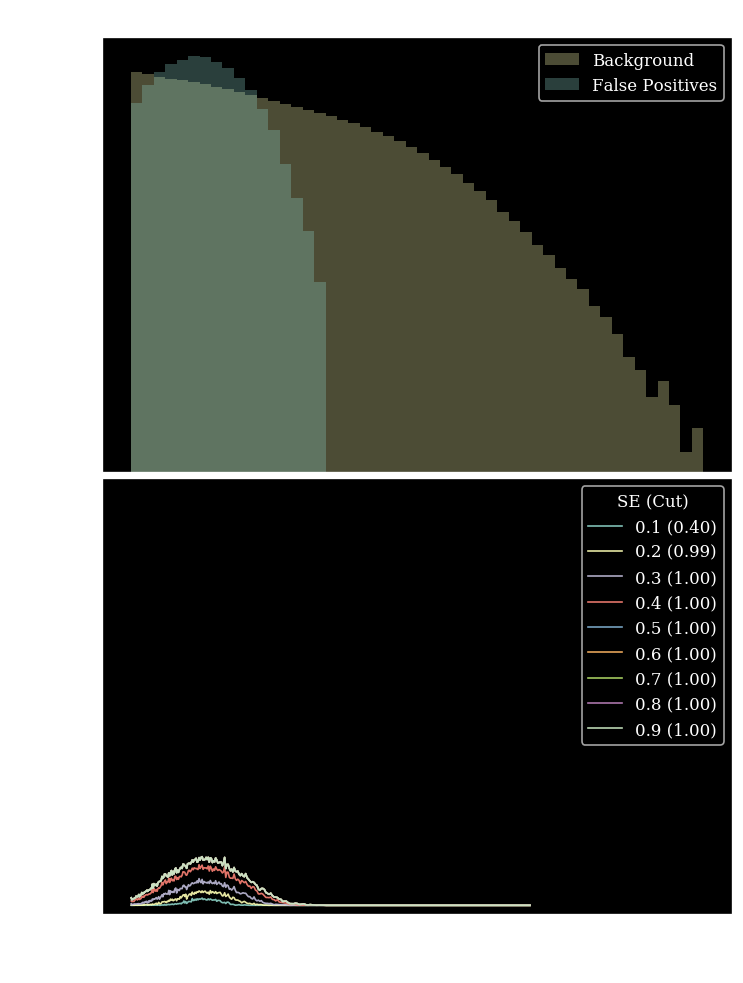

strength 500
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (299.0s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 8.5492, 1/JSD: 1872.3852


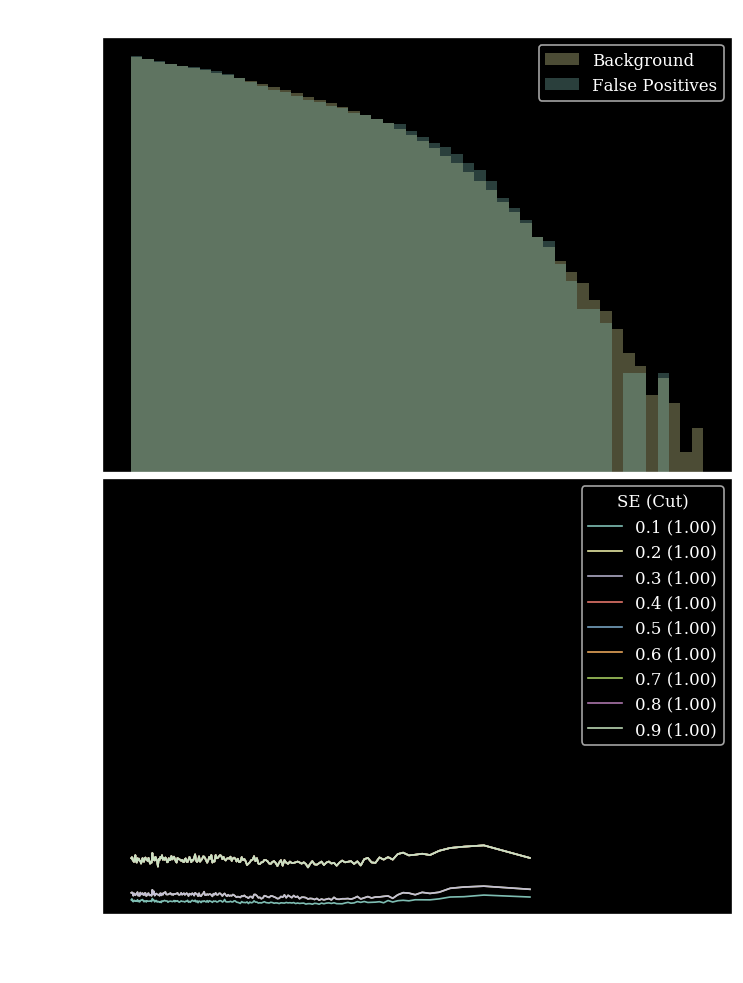

strength 500
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (295.1s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 15.5440, 1/JSD: 124.1036


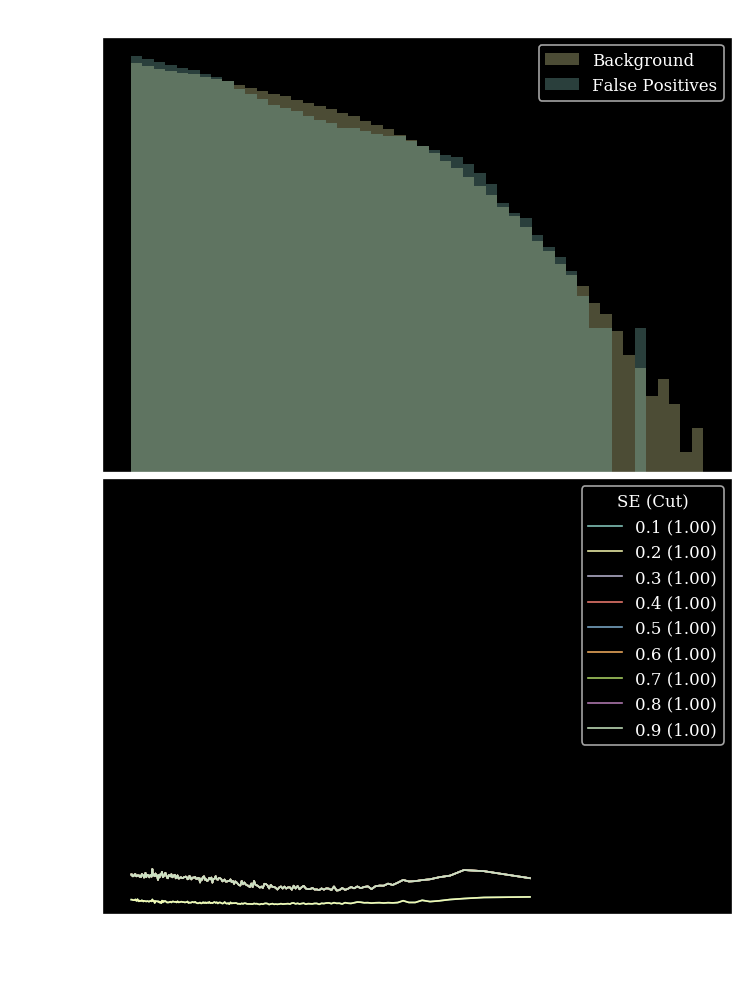

strength 1000
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (354.7s)
 Train: loss:0.6241, acc:40% || Val: loss: 0.1584, acc:83%, R50: 9.1198, 1/JSD: 580.6324


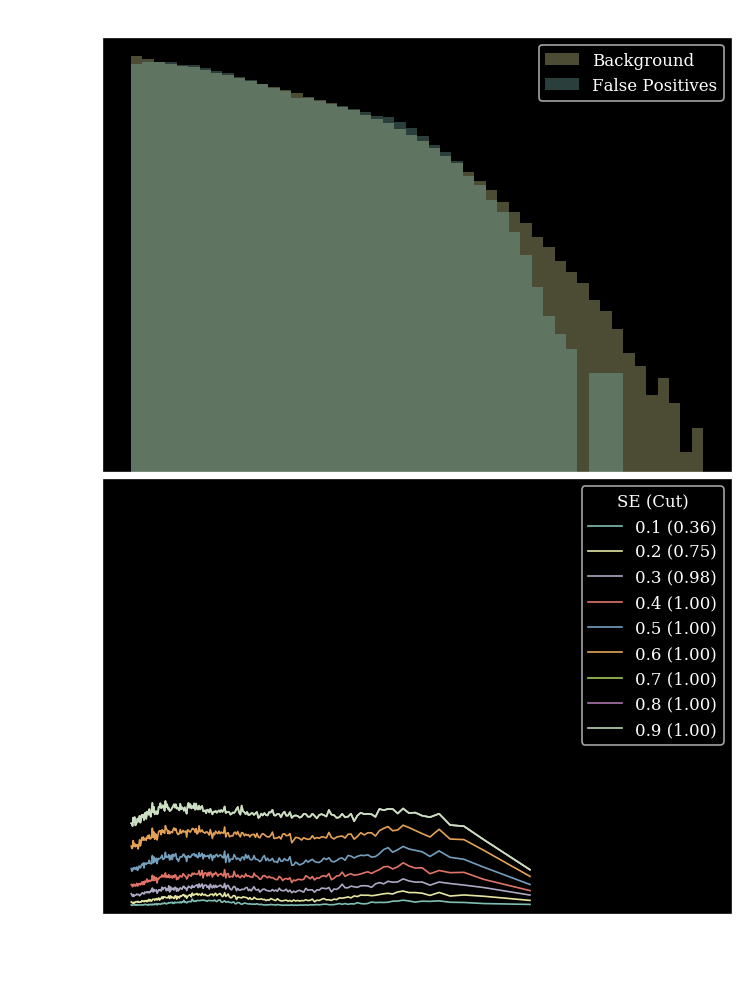

strength 1000
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (289.2s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 6.0604, 1/JSD: 689.0329


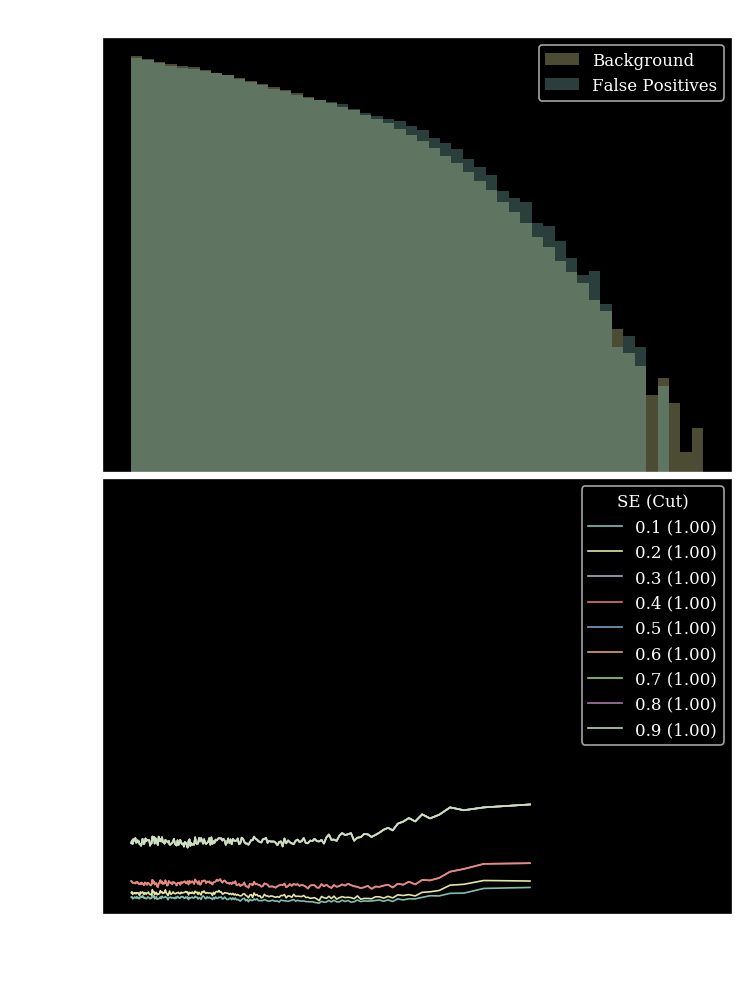

strength 1000
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (298.2s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 10.0659, 1/JSD: 952.3446


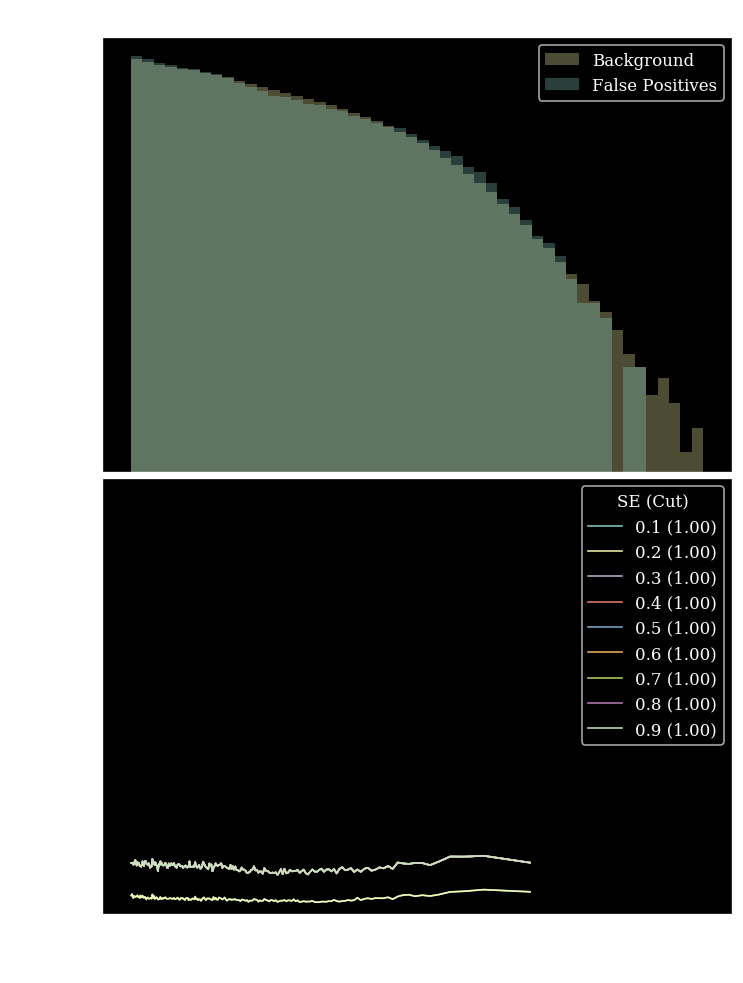

strength 1000
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (360.9s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 16.4926, 1/JSD: 117.5272


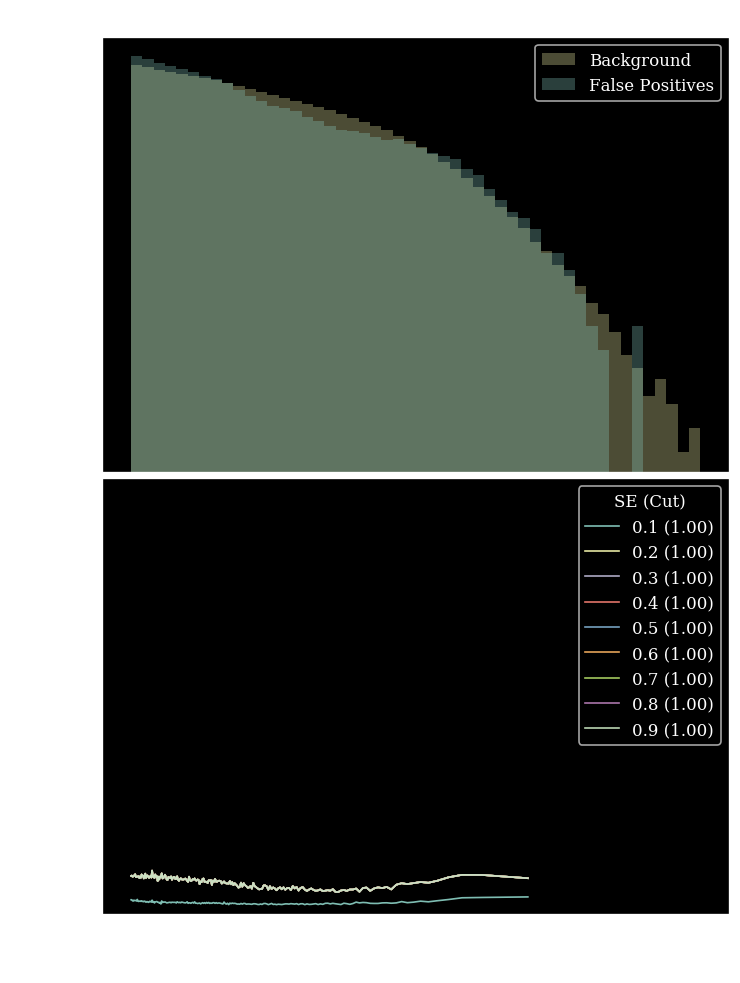

strength 1500
Entering Training...
Epoch:0001/0200  (8.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (289.1s)
 Train: loss:0.6487, acc:37% || Val: loss: 0.1703, acc:82%, R50: 8.9129, 1/JSD: 328.7644


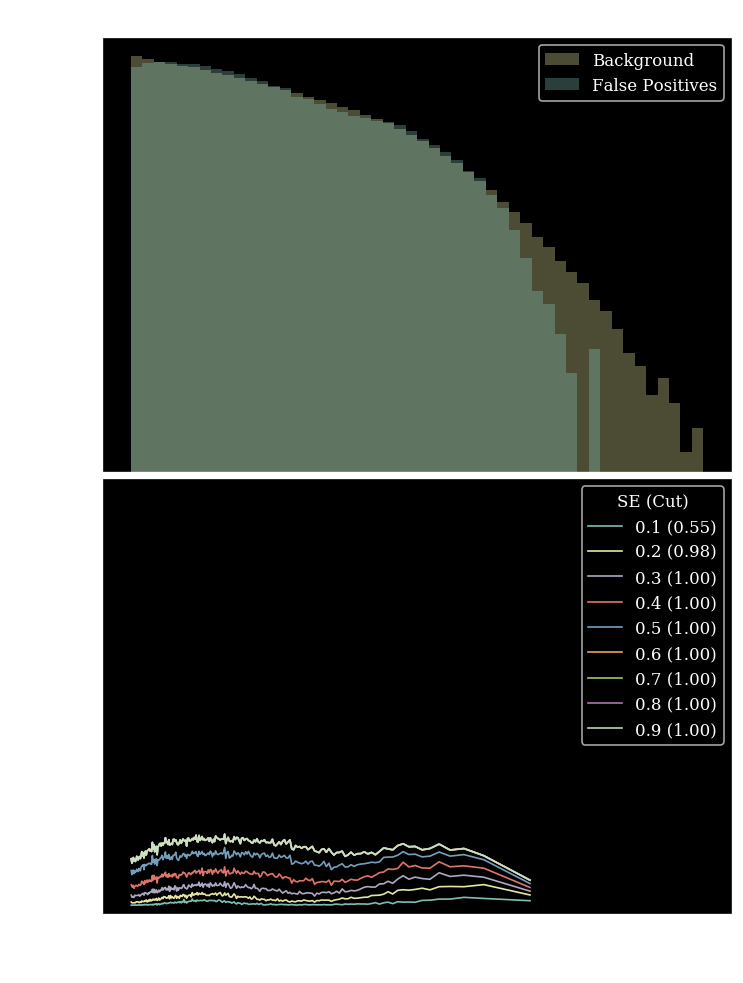

strength 1500
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (289.0s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 6.5720, 1/JSD: 770.1680


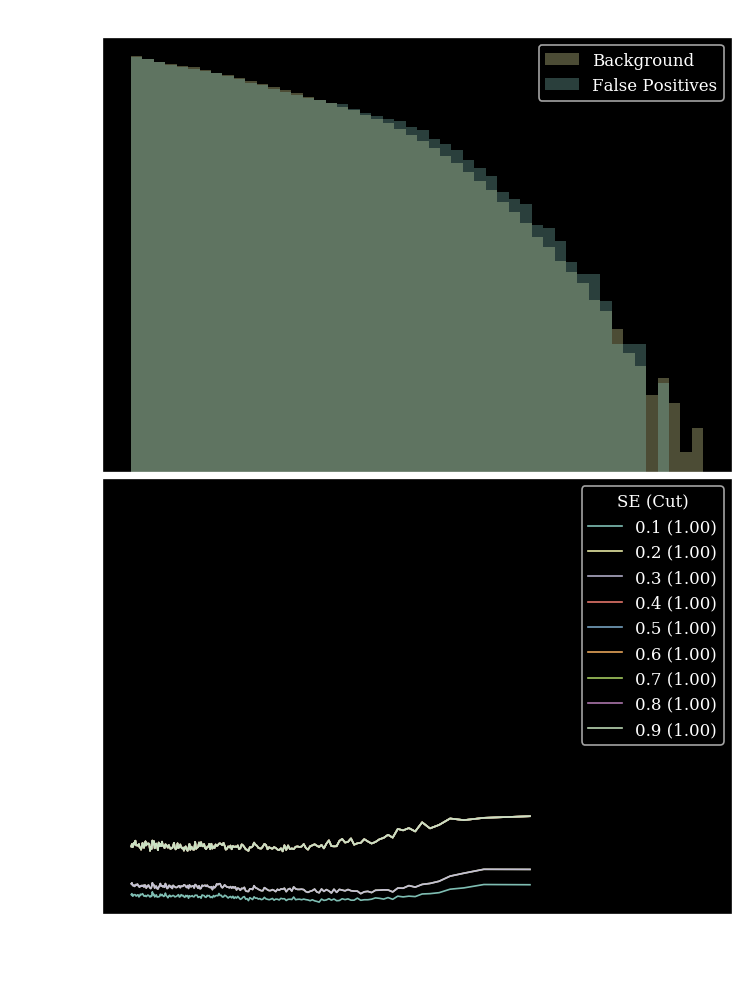

strength 1500
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (366.2s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 10.4912, 1/JSD: 773.6649


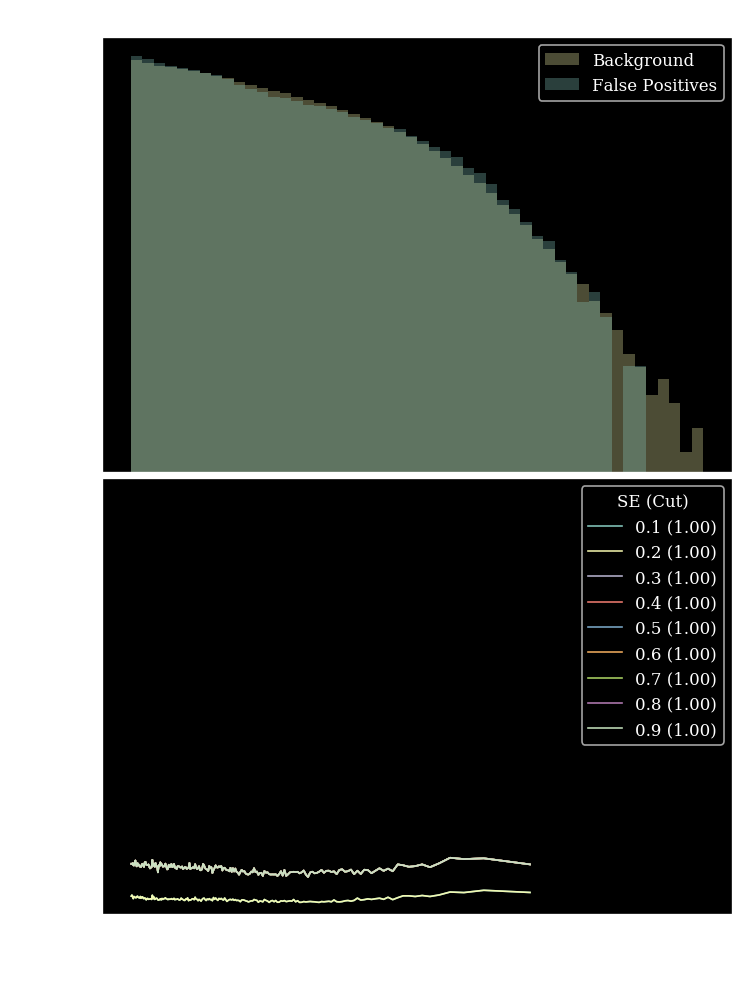

strength 1500
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (293.9s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 17.9719, 1/JSD: 88.7806


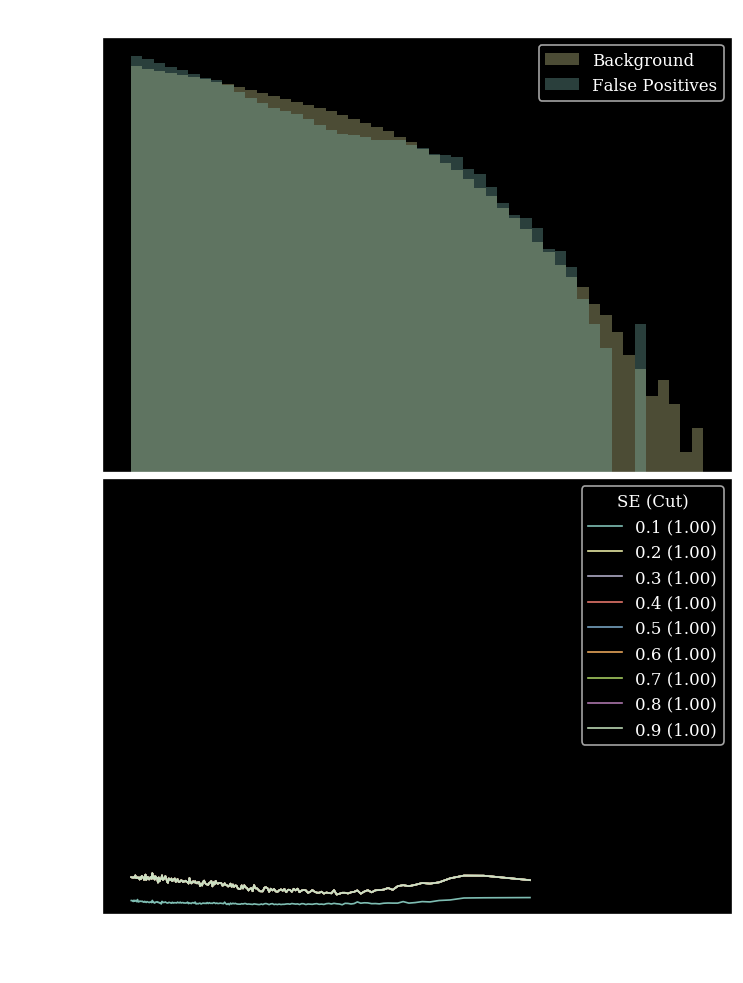

strength 2000
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (287.0s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 5.1320, 1/JSD: 403.2569


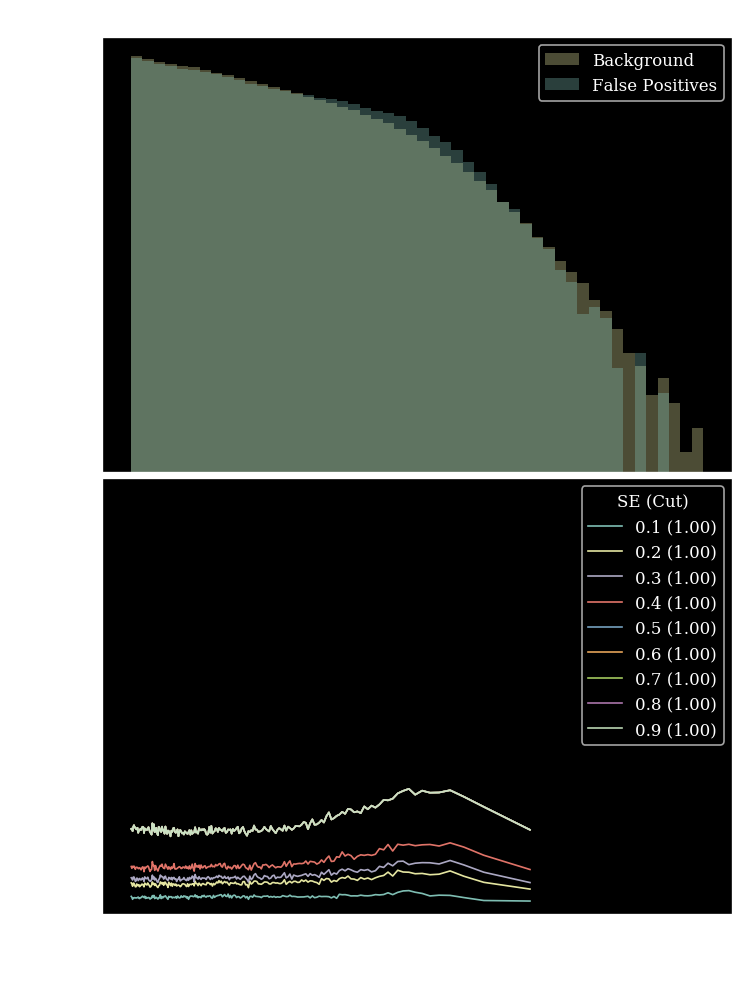

strength 2000
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (355.8s)
 Train: loss:0.7095, acc:29% || Val: loss: 0.1951, acc:80%, R50: 6.8131, 1/JSD: 801.6050


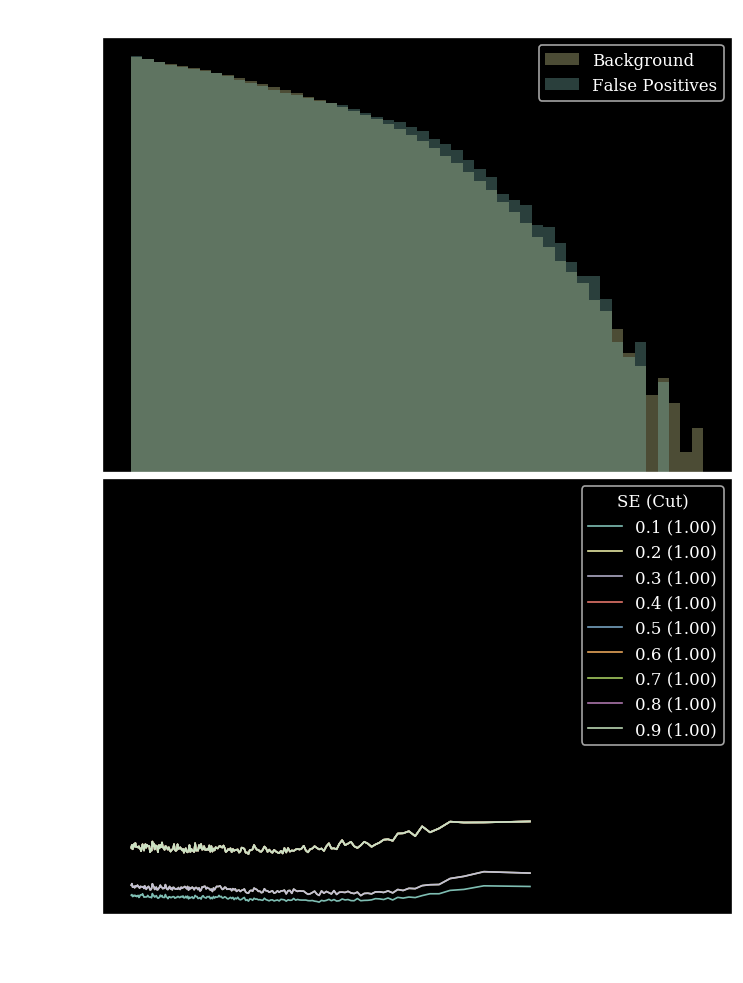

strength 2000
Entering Training...


KeyboardInterrupt: 

In [107]:
jsdR50flatstr = []
for i,frac in enumerate([1,20,45,75,100,125,200,500,1000,1500,2000,3000,5000]):
    for bins in [5,20,50,100]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=False)
        log=Logger(f"./logs/new/4096/Flat(f{frac}b{bins}).txt")
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        torch.save(model_L.state_dict(),f"./logs/new/4096/Flat(f{frac}b{bins}).pt")
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}, bins:{bins}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,
                       f=f"./logs/new/4096/Flat(f{frac}b{bins}).png")
        jsdR50flatstr.append(out)

# DisCo str

strength 1
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (657.0s)
 Train: loss:0.1999, acc:79% || Val: loss: 0.0552, acc:81%, R50: 25.7390, 1/JSD: 3.5499


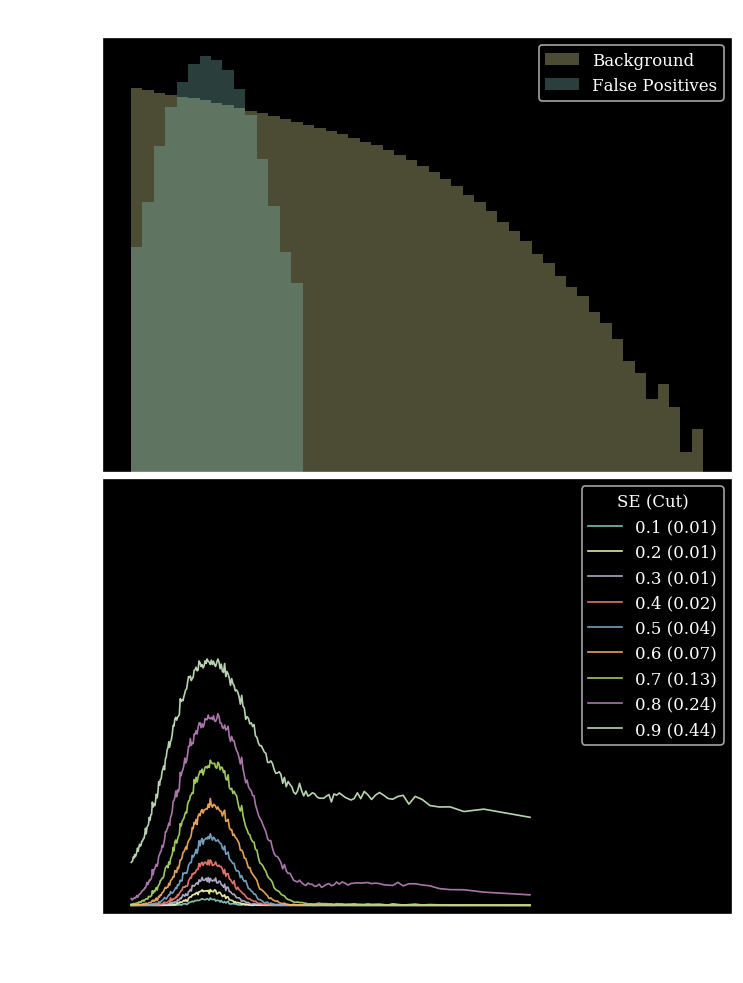

strength 5
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (658.8s)
 Train: loss:0.2232, acc:77% || Val: loss: 0.0613, acc:77%, R50: 17.8978, 1/JSD: 15.2547


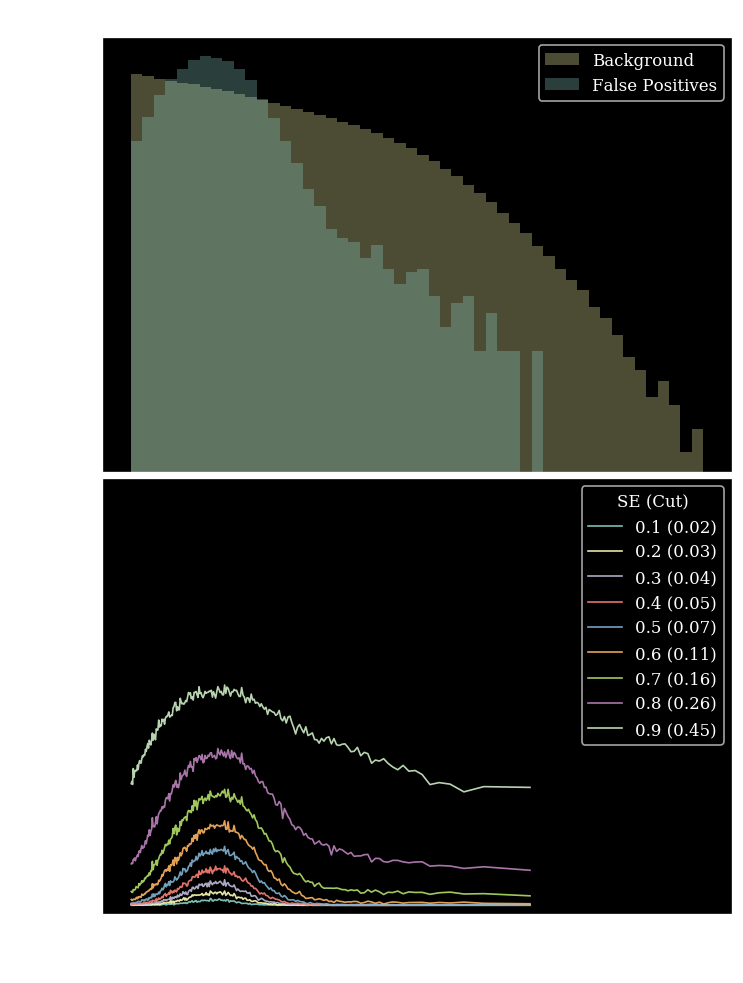

strength 10
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (659.4s)
 Train: loss:0.2333, acc:76% || Val: loss: 0.0643, acc:76%, R50: 13.4909, 1/JSD: 75.2791


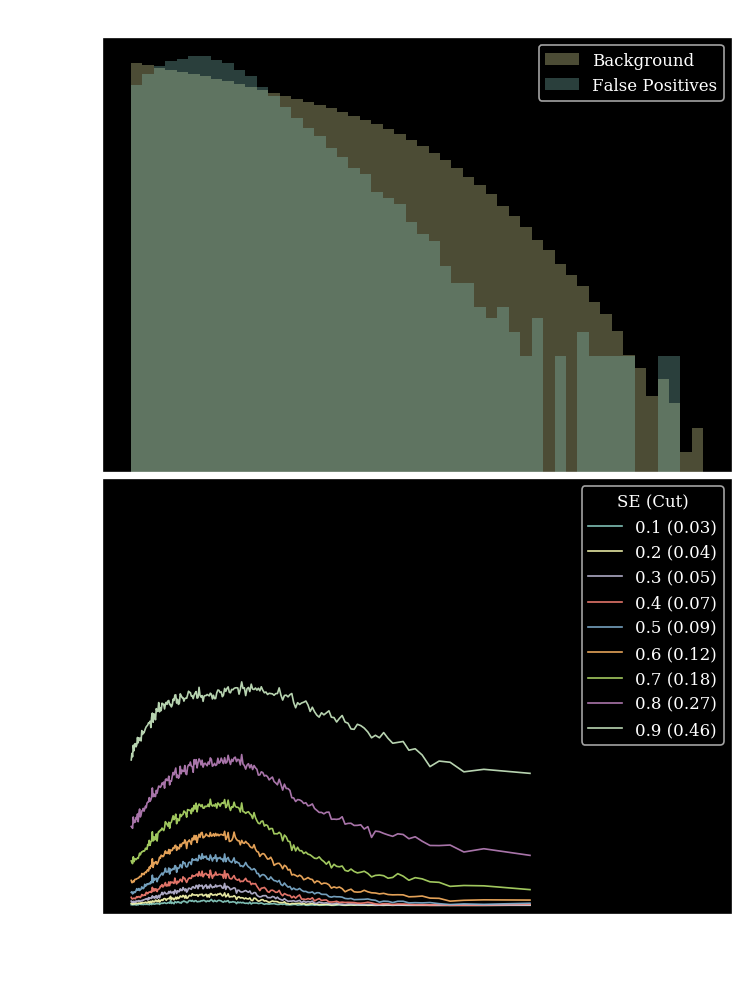

strength 20
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (659.7s)
 Train: loss:0.2701, acc:74% || Val: loss: 0.0688, acc:74%, R50: 10.2711, 1/JSD: 458.8072


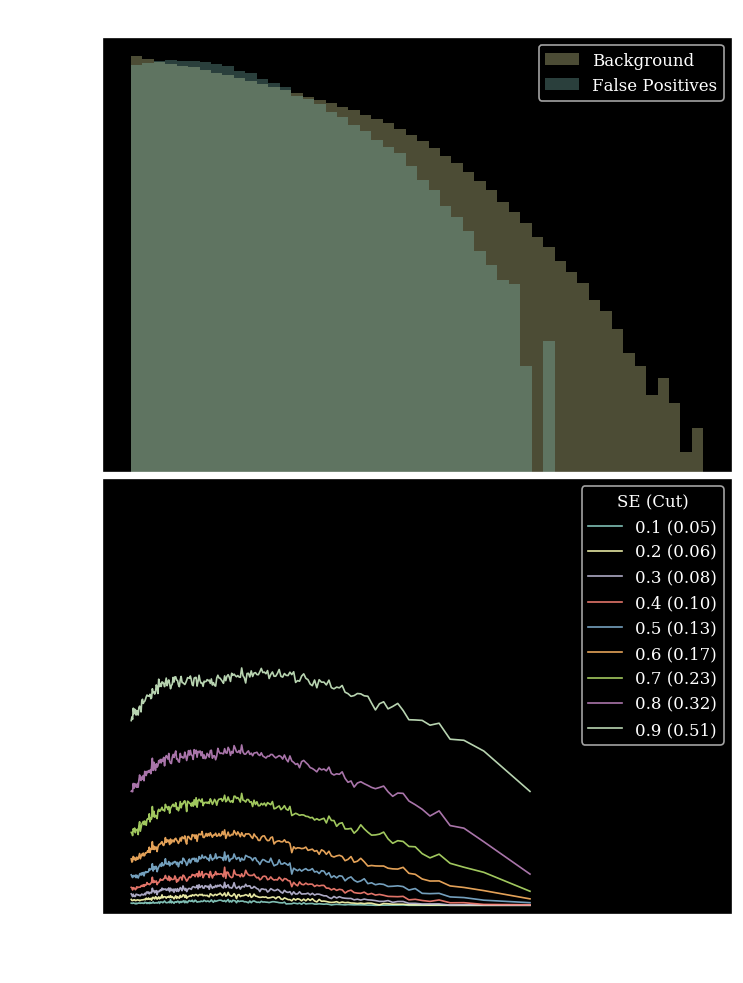

strength 30
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (659.5s)
 Train: loss:0.2992, acc:71% || Val: loss: 0.0723, acc:74%, R50: 9.2230, 1/JSD: 776.0414


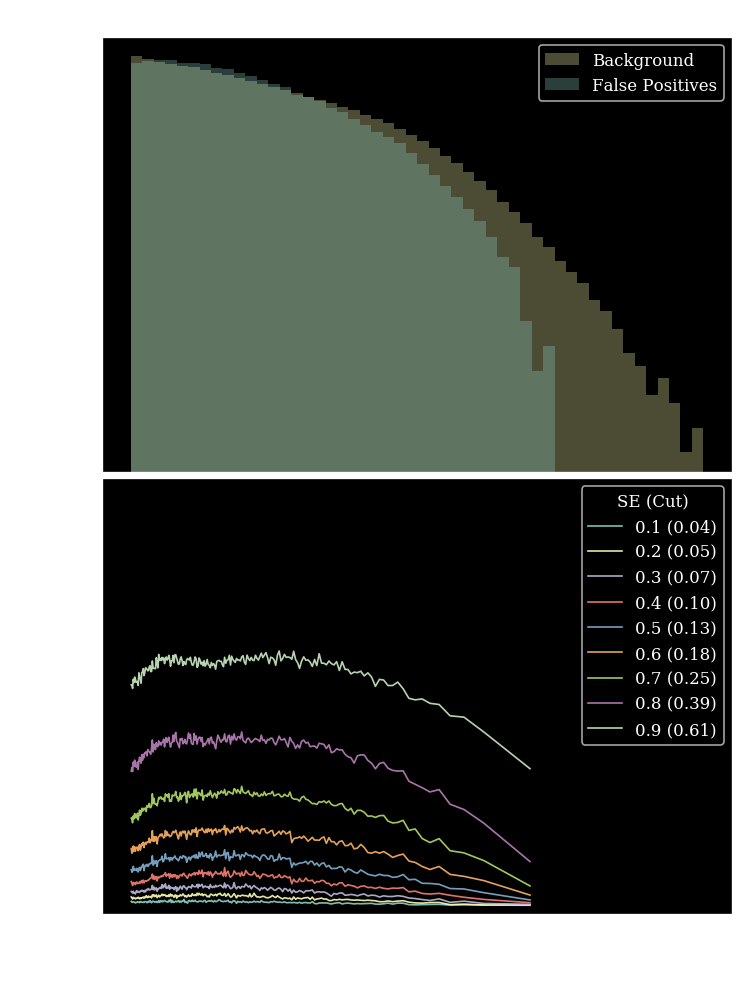

strength 50
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (694.0s)
 Train: loss:0.3621, acc:69% || Val: loss: 0.0752, acc:75%, R50: 8.5568, 1/JSD: 934.1664


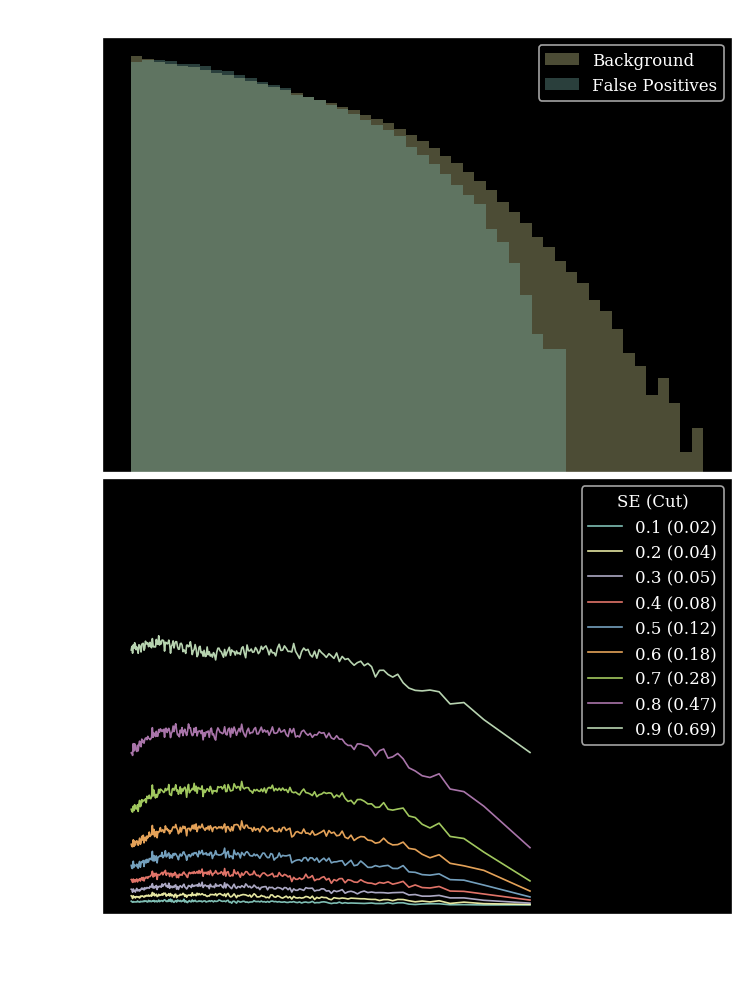

strength 100
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (659.3s)
 Train: loss:0.4513, acc:67% || Val: loss: 0.0784, acc:73%, R50: 7.2931, 1/JSD: 1104.8127


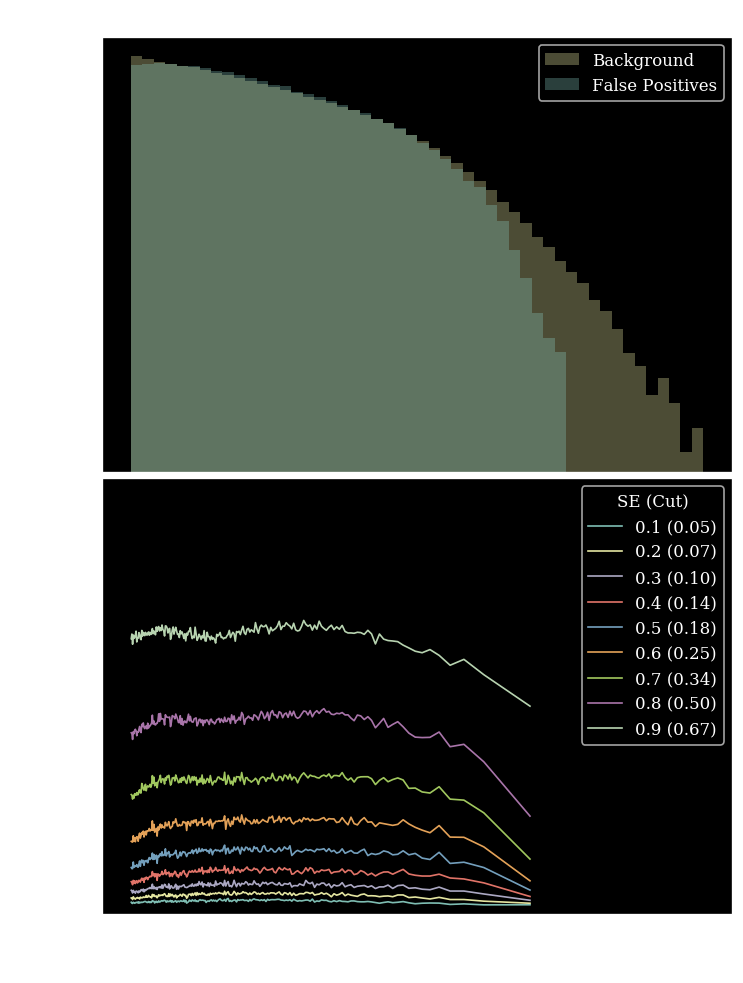

strength 150
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (659.0s)
 Train: loss:0.4374, acc:61% || Val: loss: 0.0870, acc:69%, R50: 4.3044, 1/JSD: 1912.1477


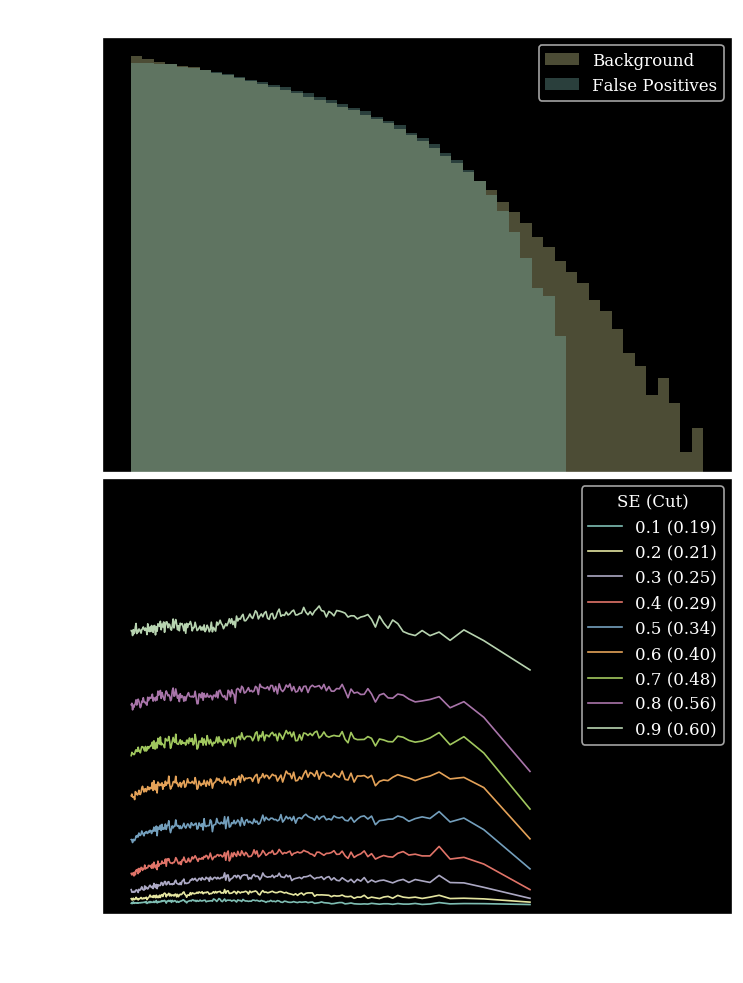

strength 200
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (695.7s)
 Train: loss:0.5344, acc:55% || Val: loss: 0.0921, acc:66%, R50: 3.3202, 1/JSD: 3346.6521


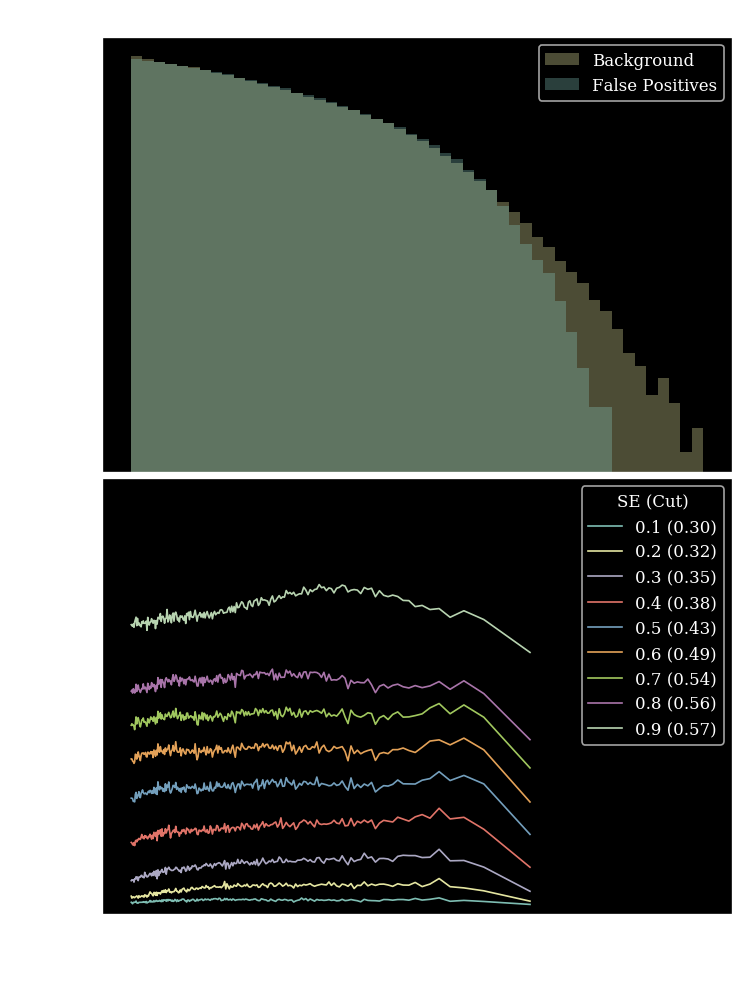

strength 1000
Entering Training...
Epoch:0001/0200  (8.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (661.0s)
 Train: loss:1.1819, acc:49% || Val: loss: 0.0995, acc:60%, R50: 2.5172, 1/JSD: 6675.7447


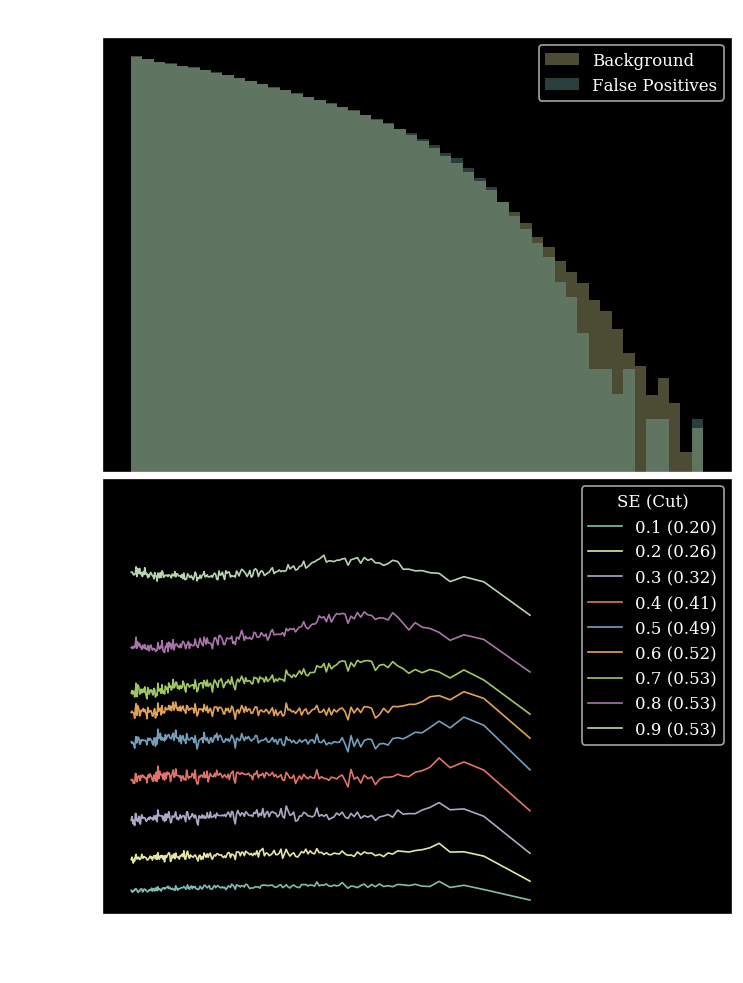

In [108]:
jsdR50Disco = []
for i,frac in enumerate([1,5,10,20,30,50,100,150,200,1000]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    log=Logger(f"./logs/new/4096/DisCo(f{frac}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),f"./logs/new/4096/DisCo(f{frac}).pt")
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,
                       f=f"./logs/new/4096/DisCo(f{frac}).png")

    jsdR50Disco.append(out)

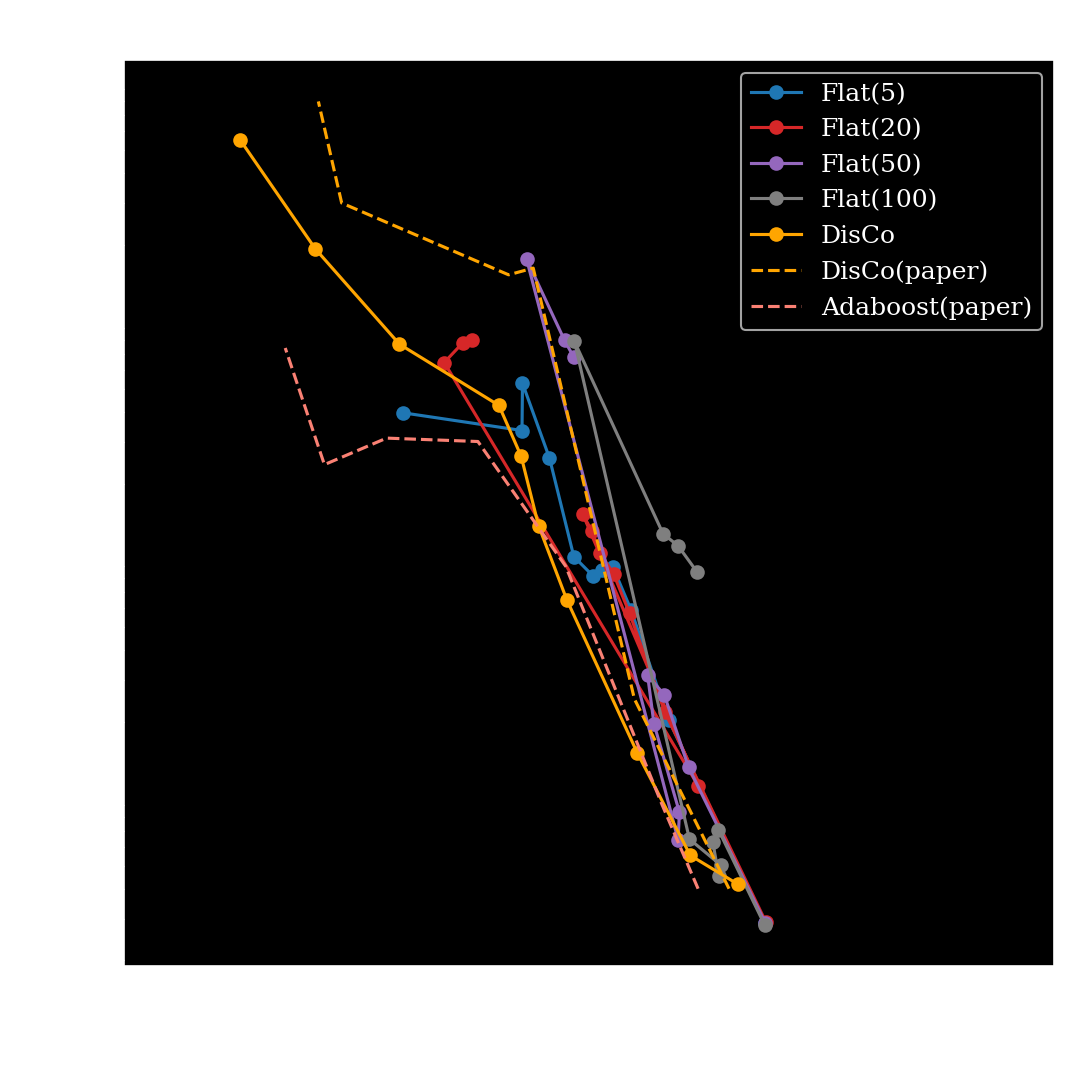

In [110]:
JSD,R50 = zip(*jsdR50flatstr[0::4])
JSDa,R50a = zip(*jsdR50flatstr[1::4])
JSDb,R50b = zip(*jsdR50flatstr[2::4])
JSDc,R50c = zip(*jsdR50flatstr[3::4])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat(5)',c='tab:blue')
plt.errorbar(R50a,JSDa,fmt='-o',label='Flat(20)',c='tab:red')
plt.errorbar(R50b,JSDb,fmt='-o',label='Flat(50)',c='tab:purple')
plt.errorbar(R50c,JSDc,fmt='-o',label='Flat(100)',c='tab:gray')
plt.errorbar(R502,np.array(JSD2),fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("4096 batch size",fontsize=20)
fig.savefig(f"./logs/new/4096/PhaseSpace.png")

# Phase Space Calculation. Batch size 32768

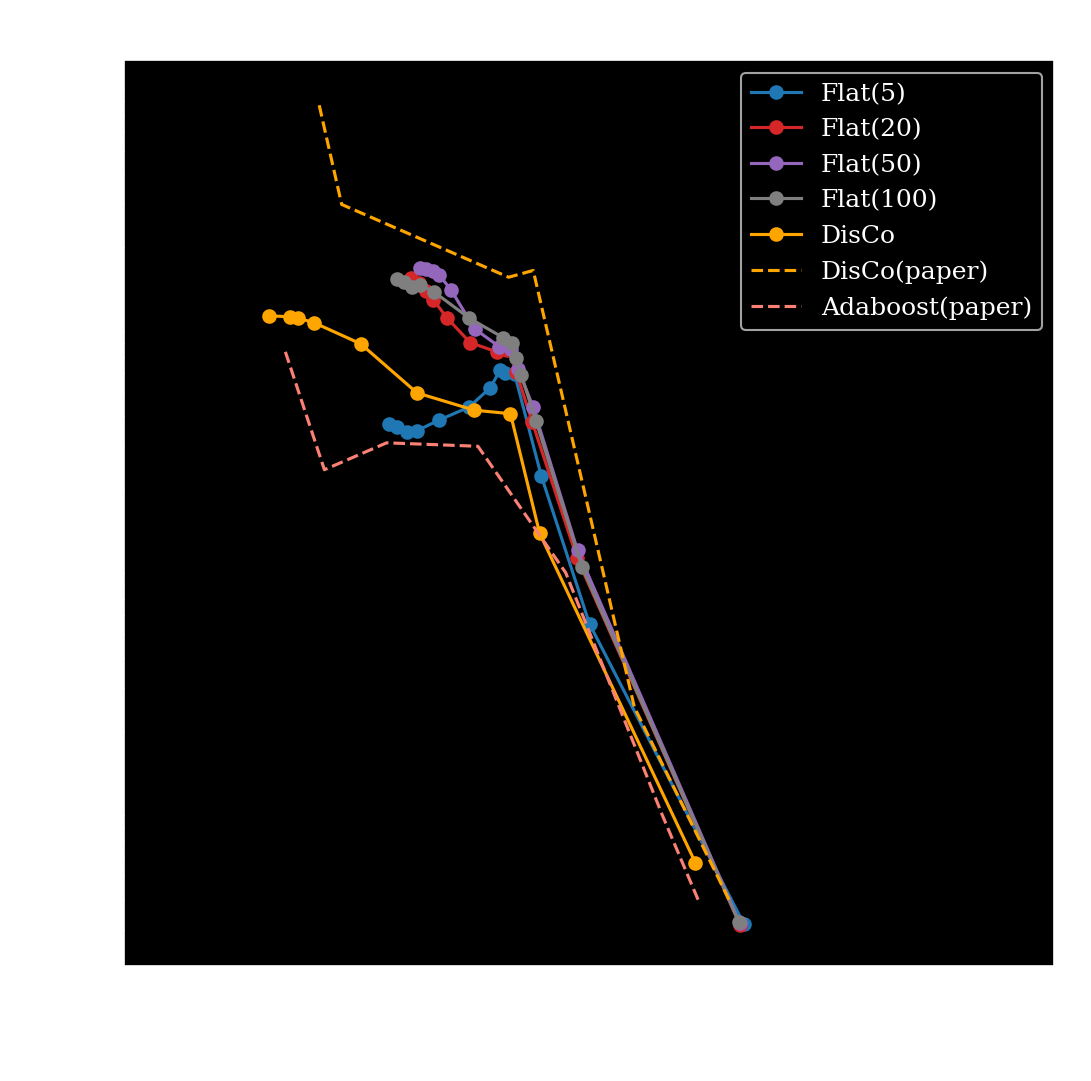

In [74]:
JSD,R50 = zip(*jsdR50flatstr[0::4])
JSDa,R50a = zip(*jsdR50flatstr[1::4])
JSDb,R50b = zip(*jsdR50flatstr[2::4])
JSDc,R50c = zip(*jsdR50flatstr[3::4])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat(5)',c='tab:blue')
plt.errorbar(R50a,JSDa,fmt='-o',label='Flat(20)',c='tab:red')
plt.errorbar(R50b,JSDb,fmt='-o',label='Flat(50)',c='tab:purple')
plt.errorbar(R50c,JSDc,fmt='-o',label='Flat(100)',c='tab:gray')
plt.errorbar(R502,np.array(JSD2),fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("32768 batch size",fontsize=20)
#fig.savefig(f"./logs/new/32768/PhaseSpace.png")

# Phase Space Calculation. Batch size 16384

In [124]:
class Metrics2():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==0).sum()


        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[targets==1],bins=50,normed=True,range=[0,1])
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=bins,normed=True,range=[0,1])
                JSD = 0.5*(entropy(hist1,0.5*(hist1+hist2),base=2)+entropy(hist2,0.5*(hist1+hist2),base=2))#*(bins[1]-bins[0])
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)

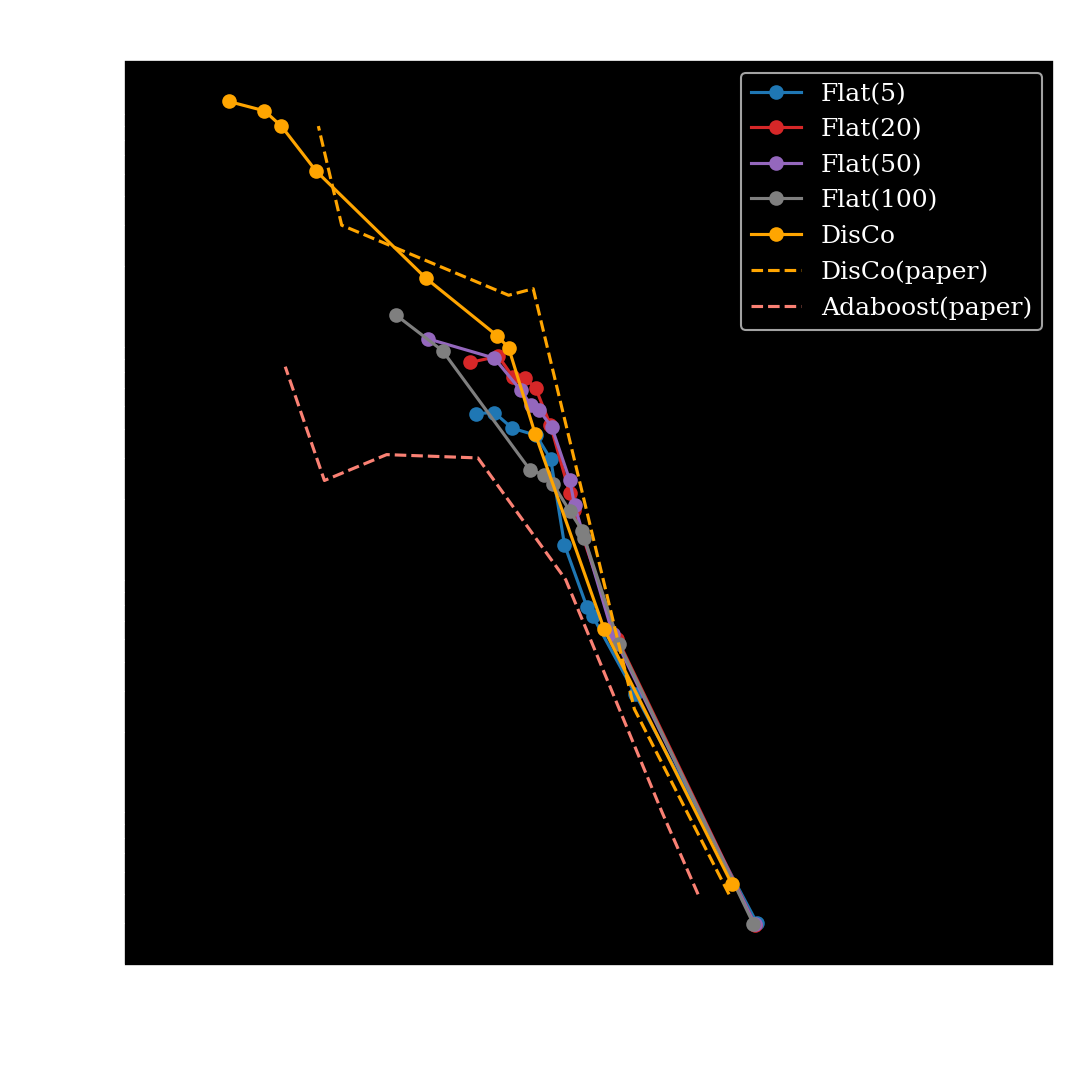

In [99]:
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
c = ["tab:blue","tab:red","tab:purple","tab:gray"]
for i,b in enumerate([5,20,50,100]):
    jsdr50 = list()
    files = glob.glob(f"./logs/new/16384/Flat*b{b}).pt")
    for f in files:
        model_L.load_state_dict(torch.load(f))
        out=metric_calc(model=model_L,X=X,y=test_labels,x_biased=test[:,0])
        jsdr50.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split('b')[0] for f in files],dtype=int))
    jsd,r50 = zip(*np.array(jsdr50)[sort])
    plt.errorbar(r50,jsd,fmt='-o',label=f'Flat({b})',c=c[i])
jsdr50 = list()
files = glob.glob("./logs/new/16384/DisCo*.pt")
for f in files:
    model_L.load_state_dict(torch.load(f))
    out=metric_calc(model=model_L,X=X,y=test_labels,x_biased=test[:,0])
    jsdr50.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split('b')[0] for f in files],dtype=int))
jsd,r50 = zip(*np.array(jsdr50)[sort])
plt.errorbar(r50,jsd,fmt='-o',label='DisCo',c='orange')

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    

plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("16384 batch size",fontsize=20)
#fig.savefig(f"./logs/new/16384/PhaseSpace.png")

# Phase Space Calculation. Batch size 2048

Text(0, 0.5, '1/JSD')

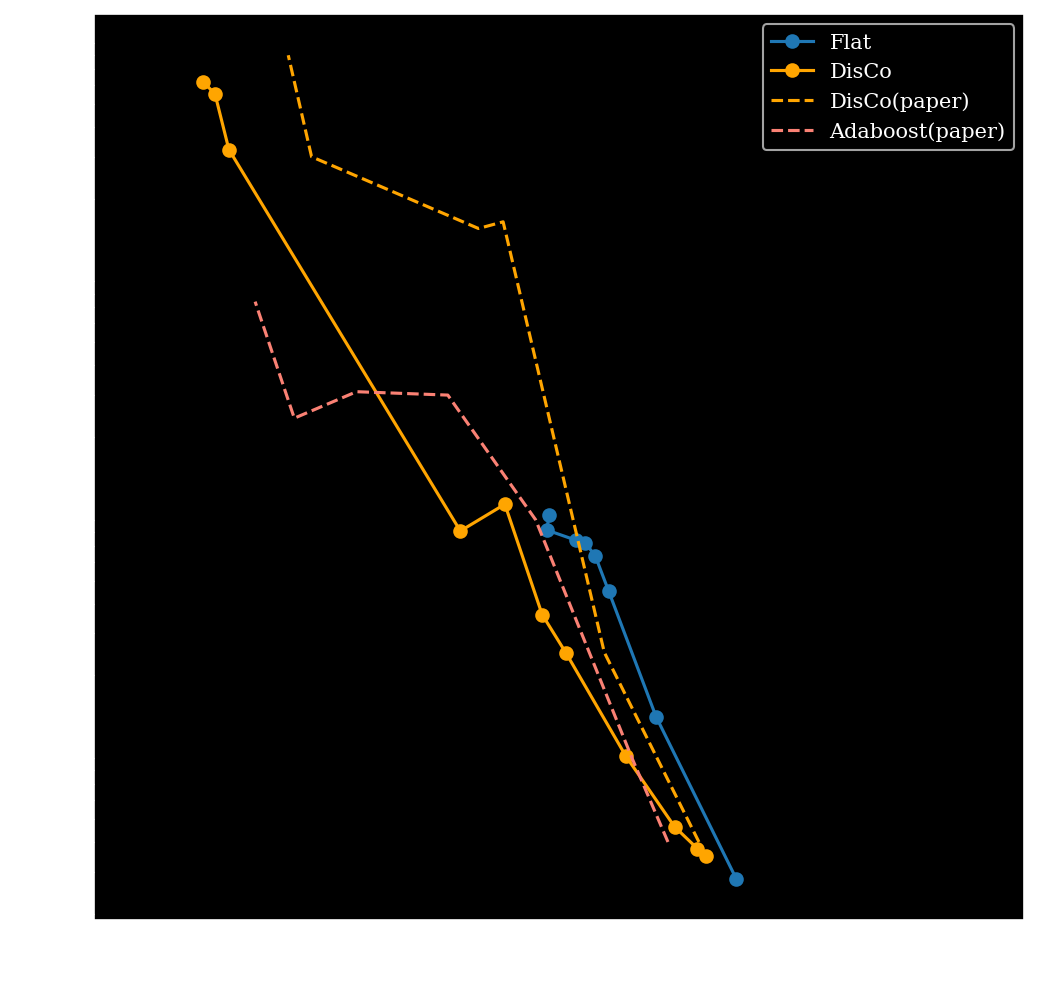

In [64]:
JSD,R50 = zip(*jsdR50flatstr[:-1])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat',c='tab:blue')
plt.errorbar(R502,np.array(JSD2),fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right')
plt.xlabel('R50')
plt.ylabel('1/JSD')